In [1]:
import numpy as np
import scipy as sp
import scipy.optimize as opt
import matplotlib.pyplot as plt
import sys
import time

In [2]:
N_x = 20
N_y = 20
N_tot = N_x*N_y 
V = 1.
t = -V
t_prime = 0.16
U = 2.5
Doping = 0.16
T = 0.15

Periodic_Boundaries_x = True
Periodic_Boundaries_y = True

D = V
TwoBandModel = False

Magnetic_z_bias = False




np.set_printoptions(threshold=sys.maxsize,suppress=True)

In [3]:
n_filling = 1-Doping#1 for half-filling 
beta = 1./T
print(int(N_tot*n_filling))

336


In [4]:
H_0 = np.zeros([2*N_tot,2*N_tot])#Hamiltonian without any Deltas
#GapVector = np.zeros(4*N_tot) #Contains first the n_ups, then n_downs, then Re(d_up d_down), then Im

In [5]:
QuantumNumbers = []  #To write a single index insead of (x,y,s).
for i in range(N_y):
    for j in range(N_x):
        for s in (1,-1):
            QuantumNumbers.append([j,i,s])

In [6]:
H_0 = np.zeros([2*N_tot,2*N_tot],dtype = "complex")  #Fill up H_0 without the Gaps

for i in range(2*N_tot):     
    for j in range(2*N_tot):  
        x1,y1,s1 = QuantumNumbers[i]
        x2,y2,s2 = QuantumNumbers[j]
        
        
        #Implement Nearest-Neighbour-Hopping:
        if(x1 == x2+1 or x1 == x2-1):
            if(s1 == s2 and y1 == y2):
                H_0[i,j]+= t
        
        if(y1 ==y2+1 or y1 == y2-1):
            if(s1 == s2 and x1 == x2):
                H_0[i,j]+= t
        
        
        #Implement Next-Nearest-Neighbour-Hopping:
        if(x1 == x2+1 or x1 == x2-1):
            if(y1 ==y2+1 or y1 == y2-1):
                if(s1 == s2):
                
                    H_0[i,j]+= t_prime

                
                
        if(Periodic_Boundaries_x == True): #implement boundaries
            
            #for nearest neighbour hopping
            if(x1 == 0 and x2 == N_x-1):
                if(s1 == s2 and y1 == y2):
                    H_0[i,j]+= t
            if(x2 == 0 and x1 == N_x-1):
                if(s1 == s2 and y1 == y2):
                    H_0[i,j]+= t
                    
        if(Periodic_Boundaries_y == True):
            
            #for nearest neighbour hopping
            if(y2 == 0 and y1 == N_y-1):
                if(s1 == s2 and x1 == x2):
                    H_0[i,j]+= t
            if(y1 == 0 and y2 == N_y-1):
                if(s1 == s2 and x1 == x2):
                    H_0[i,j]+= t
                    
                    
        if(Periodic_Boundaries_x == True):
            
            #For next nearest neighbour hopping
            if(x1 == 0 and x2 == N_x-1):
                if(Periodic_Boundaries_y == True):
                    if(y1%N_y ==(y2+1)%N_y or y1%N_y == (y2-1)%N_y): #with modulus to account for corner-corner-hopping
                        if(s1 == s2):
                            H_0[i,j]+= t_prime
                else:
                    if(y1 ==y2+1 or y1 == y2-1): #with modulus to account for corner-corner-hopping
                        if(s1 == s2):
                            H_0[i,j]+= t_prime
                            
                            
            if(x2 == 0 and x1 == N_x-1):
                if(Periodic_Boundaries_y == True):
                    if(y1%N_y ==(y2+1)%N_y or y1%N_y == (y2-1)%N_y):
                        if(s1 == s2):
                            H_0[i,j]+= t_prime
                else:
                    if(y1 ==y2+1 or y1 == y2-1):
                        if(s1 == s2):
                            H_0[i,j]+= t_prime
                        
        if(Periodic_Boundaries_y == True):
            
            #For next nearest neighbour hopping
            if(y2 == 0 and y1 == N_y-1):
                if(x1 == x2+1 or x1 == x2-1):  # Here without the modulus, since else we would double count the corner-corner hopping
                    if(s1 == s2):
                        H_0[i,j]+= t_prime
            if(y1 == 0 and y2 == N_y-1):
                if(x1 == x2+1 or x1 == x2-1):
                    if(s1 == s2):
                        H_0[i,j]+= t_prime
                    
                    
                    
        if(TwoBandModel == True): #implement offset if the atoms are distinct
            if(x1==x2 and y1==y2 and s1 ==s2):
                if((x1%2 == y1%2)):
                    H_0[i,j]+=D
        if(Magnetic_z_bias == True): #apply a tiny magnetic field
            if(x1 ==x2 and y1 == y2):
                if(s1==s2==1):
                    H_0 +=0.0001
            
H_0 = np.array(H_0) 

In [7]:
def Get_H(GapVector,H_0): #Returns the full Hamiltonian for a given GapVector
    
    H = np.array(H_0)
    
    GapVector = np.real(GapVector)
    
    N_ups = GapVector[:N_tot]
    N_downs = GapVector[N_tot:2*N_tot]
    Re_up_down = GapVector[2*N_tot:3*N_tot]
    Im_up_down = GapVector[3*N_tot:4*N_tot]
    
    DiagonalEntries = U*np.append(N_downs,N_ups).reshape(2,N_tot).transpose().flatten()
    OffDiags = U*np.append(-Re_up_down+1j*Im_up_down,np.zeros(N_tot)).reshape(2,N_tot).transpose().flatten()[:-1]
    
    H = H + np.diag(DiagonalEntries) + np.diag(OffDiags,1) + np.diag(OffDiags.conjugate(),-1)
                  
    return np.array(H)

In [8]:
def n_occ(Energy,mu):
    return 1./(np.exp(beta*(Energy-mu))+1)

In [9]:
def Exp_Val_Matrix(Matrix,Energies,mu):
    N_Vector = n_occ(Energies,mu)

    BigM = (N_Vector*Matrix)@Matrix.transpose().conjugate()

    return BigM.transpose()
    

In [10]:
def Get_N_tot(mu,Energies):
    
    return np.sum(n_occ(Energies,mu))

In [12]:
def Next_Gap_Vector(GapVector,GetEnergy=False,ReturnBoth = False,ReturnSpectral = False,ReturnThree = False):

    H = Get_H(GapVector,H_0)
    epsilons, Eigenvectors = sp.linalg.eigh(H)
    
    
    N_filled = int(N_tot*n_filling)
    mu_initial = (epsilons[N_filled]+epsilons[N_filled-1])/2.
    
    mu = opt.root(lambda mu: Get_N_tot(mu,epsilons)-int(N_tot*n_filling),x0 = mu_initial).x[0]

    
    N_ups_new = []
    N_downs_new = []
    Re_UpDown = []
    Im_UpDown = []
    ExpValMatrix = Exp_Val_Matrix(Eigenvectors,epsilons,mu)
    for i in range(N_tot):
        N_ups_new.append(np.real(ExpValMatrix[2*i,2*i]))
        N_downs_new.append(np.real(ExpValMatrix[2*i+1,2*i+1]))
        D_up_down = ExpValMatrix[2*i,2*i+1]
        Re_UpDown.append(np.real(D_up_down))
        Im_UpDown.append(np.imag(D_up_down))

    NewGapVector = np.append(N_ups_new,np.append(N_downs_new,np.append(Re_UpDown,Im_UpDown)))
    
    
    if(GetEnergy == True):
        N_ups = GapVector[:N_tot]
        N_downs = GapVector[N_tot:2*N_tot]
        D_UpDowns = GapVector[2*N_tot:3*N_tot] + 1j*GapVector[3*N_tot:4*N_tot]

        #To calculate the energy, Gunnarsson and Zaanen have a sign error in their very last term of eq. 2.
        #Check Energy in TD limit pls
        if(T == 0):
            Energy = sum(n_occ(epsilons,mu)*(epsilons)) - U*sum(N_ups*N_downs) + U*sum(np.real(D_UpDowns)**2)+U*sum(np.imag(D_UpDowns)**2)
        else:
            Energy = -T*np.sum(np.log(1+np.exp(-beta*(epsilons-mu)))) + mu*N_filled- U*sum(N_ups*N_downs) + U*sum(np.real(D_UpDowns)**2)+U*sum(np.imag(D_UpDowns)**2)
            
        if(ReturnSpectral ==True):
            return epsilons, mu
        if(ReturnBoth == True):
            return np.real(NewGapVector), Energy/int(N_tot)
        if(ReturnThree == True):
            return np.real(NewGapVector), Energy/int(N_tot), mu
        return Energy / int(N_tot) 
    return np.real(NewGapVector)

#Next_Gap_Vector(GapVector,GetEnergy=True,ReturnBoth = False)

In [13]:
def Plot_Arrows(GapVector):
    N_ups = GapVector[:N_tot]
    N_downs = GapVector[N_tot:2*N_tot]
    D_UpDowns = GapVector[2*N_tot:3*N_tot] + 1j*GapVector[3*N_tot:]


    Pol = N_ups-N_downs
    Pol = Pol.reshape(N_y,N_x)
    Filling = N_ups+N_downs
    Filling = Filling.reshape(N_y,N_x)
    
    N_is = N_ups+N_downs
    Phi_is = np.angle(D_UpDowns)
    M_is = np.sqrt((N_ups-N_downs)**2+4*np.abs(D_UpDowns)**2)
    Theta_is = np.arccos((N_ups-N_downs)/M_is)
    M_is = M_is.reshape(N_y,N_x)

    print(Theta_is[50]-np.pi/2)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    

    for i in range(N_x):
        for j in range(N_y):

            Angle = Phi_is[N_x*j+i]-Phi_is[0] +np.pi/2
            dx = 0.8*M_is.flatten()[N_x*j+i]*np.cos(Angle)
            dy = 0.8*M_is.flatten()[N_x*j+i]*np.sin(Angle)
            axes[0].arrow(i-dx/2,j-dy/2,dx,dy,head_width = 0.12)
    axes[0].set_xlabel("Spin Amplitude and Orientation")
    axes[0].set_xlim(-1,N_x)
    axes[0].set_ylim(-1,N_y)

    #print(Phi_is/np.pi)
    #print((Phi_is[1]-Phi_is[0])/(np.pi),(Phi_is[2]-Phi_is[1])/(np.pi),(Phi_is[3]-Phi_is[2])/(np.pi))
    print(np.mean(M_is.flatten()))

    im = axes[1].pcolormesh(Filling)
    axes[1].set_xlabel("Filling on each site")
    fig.tight_layout()
    #cax = fig.add_axes([0.99, 0.15, 0.02, 0.8])
    fig.colorbar(im,orientation='vertical')
    
    ###plt.savefig("N_18_20_U4_1over9Doping.pdf",format="pdf")
    plt.show()
    return Phi_is


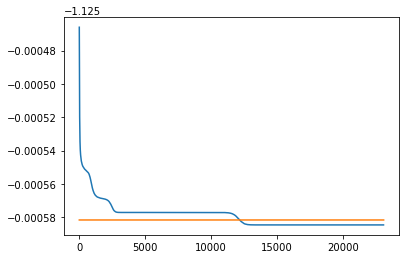

In [69]:
plt.plot(np.array(Energies)[30:])
#plt.plot(np.array([Energies2[20]]*len(mus2[20:]))+mus2[20:])
plt.plot([Energies2]*(len(Energies)-20))

In [67]:
print(max(np.abs(GapVector-Next_Gap_Vector(GapVector))))

2.275957200481571e-15


In [64]:
SpiralVector =  np.load("GapVector_Nx{}_Ny{}_U{}_Doping{}_OneBandModel_Iteration{}_tprime{}_Periodicx{}_Periodicy{}_Temperature{}_SPIRALSTATE2.npy".format(N_x,N_y,U,Doping,2000,np.abs(t_prime),Periodic_Boundaries_x,Periodic_Boundaries_y,T))

Energies2 = Next_Gap_Vector(SpiralVector,GetEnergy = True)

0 2.5 336.0000000000009
6.01221175955402e-07
0.14022121301938056


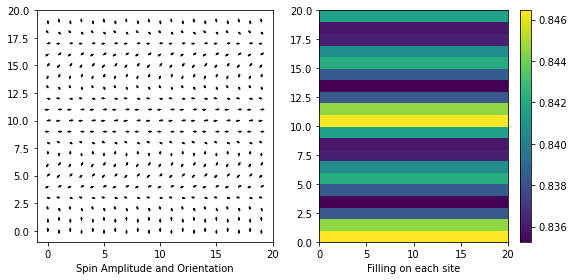

20 2.5 336.0000000000002
6.31328507472162e-07
0.14022121306489072


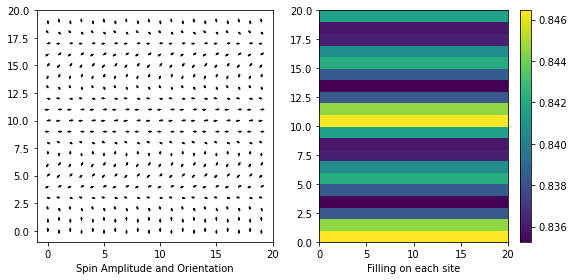

100 2.5 336.00000000000034
7.687194369943029e-07
0.1402212132487625


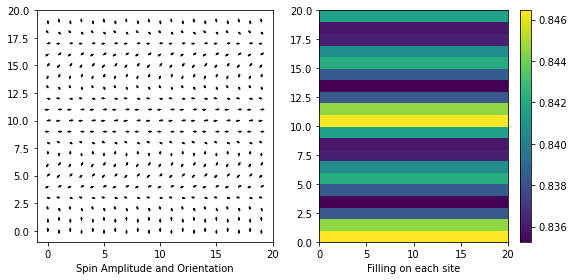

200 2.5 336.00000000000006
9.799296269985547e-07
0.14022121347648925


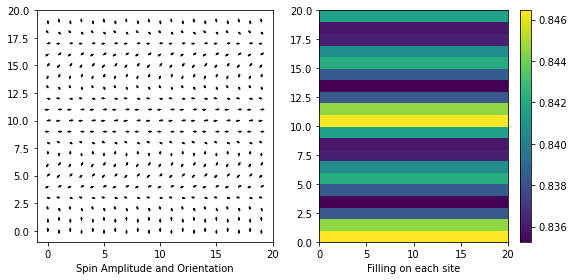

300 2.5 336.0000000000002
1.2576556520649262e-06
0.14022121371172538


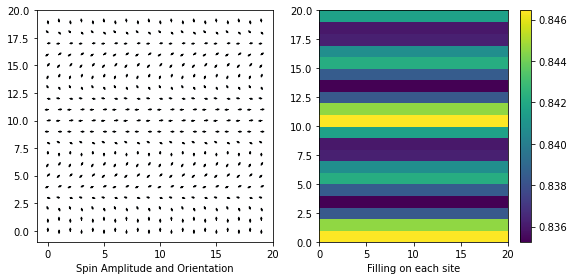

400 2.5 335.9999999999999
1.6211419553435746e-06
0.1402212139522298


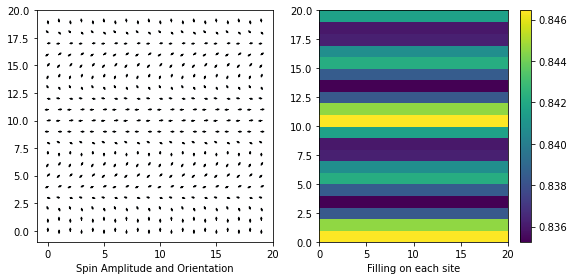

500 2.5 335.99999999999994
2.0783936924839708e-06
0.14022121418868216


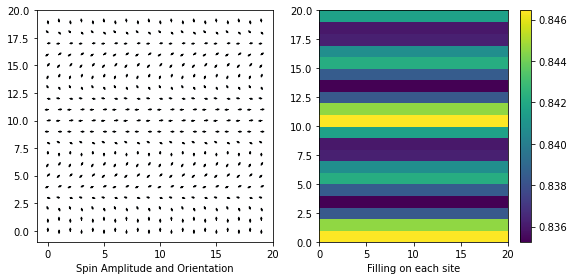

600 2.5 336.0000000000001
2.671689528499499e-06
0.1402212144287177


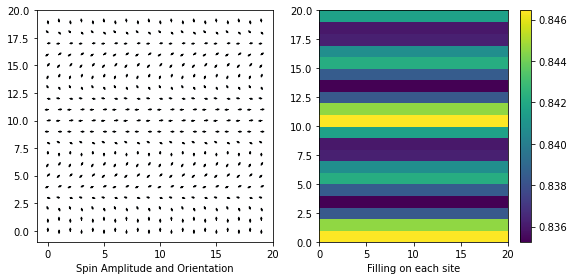

700 2.5 336.0000000000001
3.4192266906707403e-06
0.1402212146655412


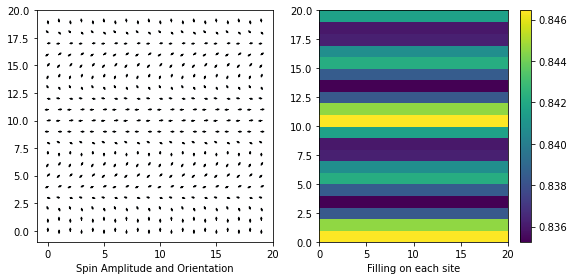

800 2.5 336.0000000000002
4.377797013344065e-06
0.14022121490377246


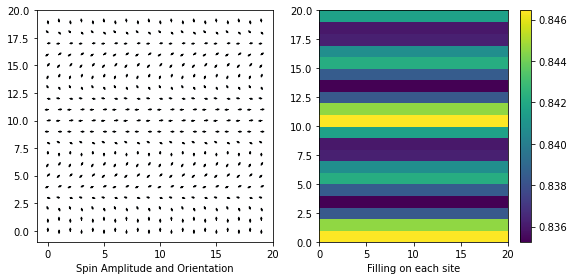

900 2.5 336.00000000000006
5.598781113169693e-06
0.1402212151419224


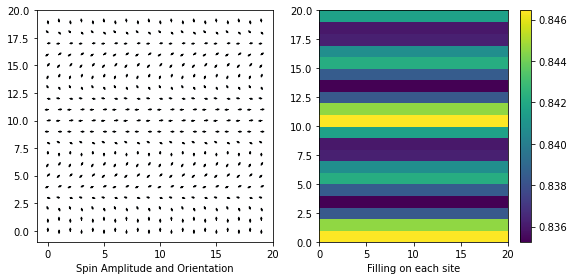

1000 2.5 335.99999999999966
7.161410862988049e-06
0.14022121538127932


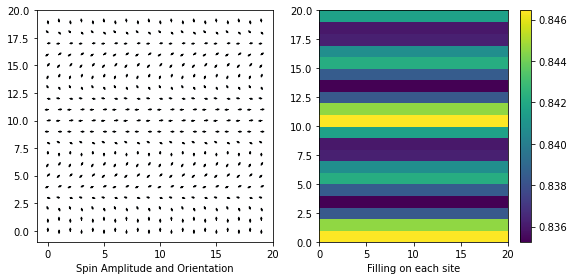

1100 2.5 336.00000000000017
9.107319328238717e-06
0.14022121561612785


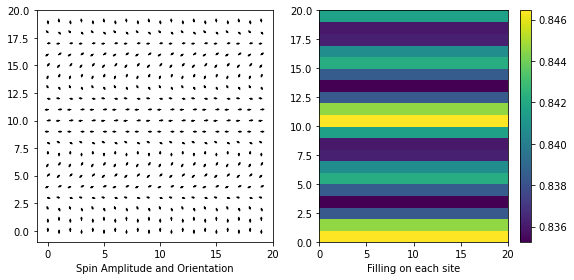

1200 2.5 335.9999999999998
1.1594314915930326e-05
0.14022121585332134


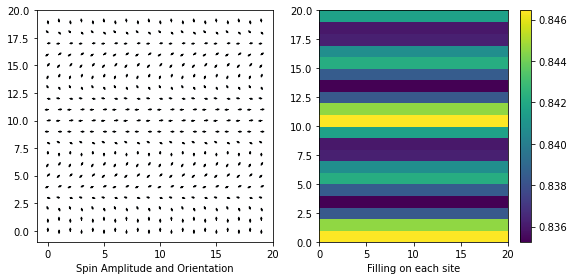

1300 2.5 336.00000000000017
1.4688514383687234e-05
0.1402212160872744


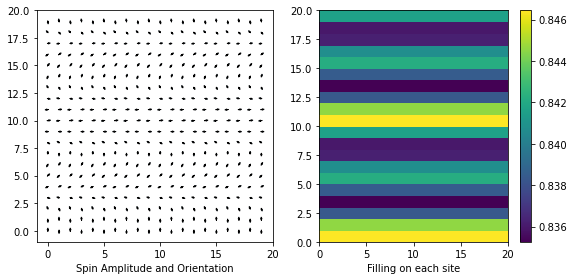

1400 2.5 335.99999999999966
1.8562495969431936e-05
0.140221216320778


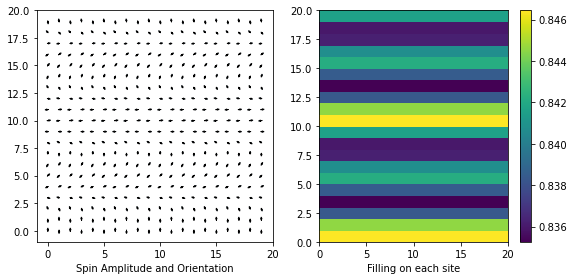

1500 2.5 336.0000000000003
2.362065786343237e-05
0.14022121656404


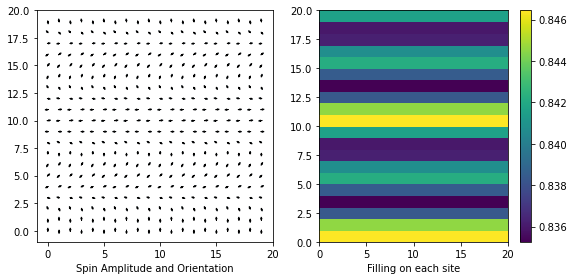

1600 2.5 336.00000000000045
2.998752605365418e-05
0.14022121680908808


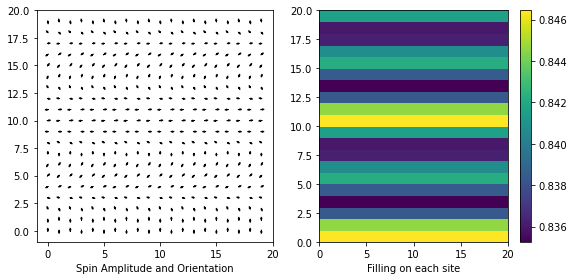

1700 2.5 335.9999999999997
3.797450874354347e-05
0.1402212170575472


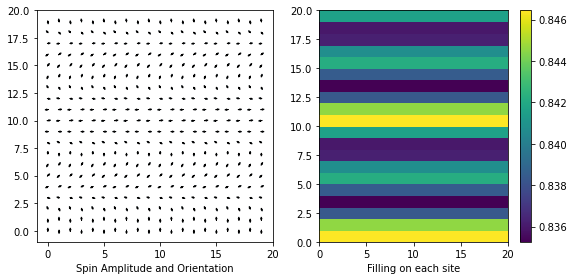

1800 2.5 336.0
4.799511065778361e-05
0.1402212173128803


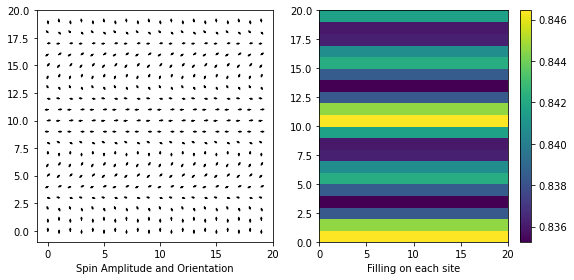

1900 2.5 335.99999999999983
6.086147172035261e-05
0.1402212175857494


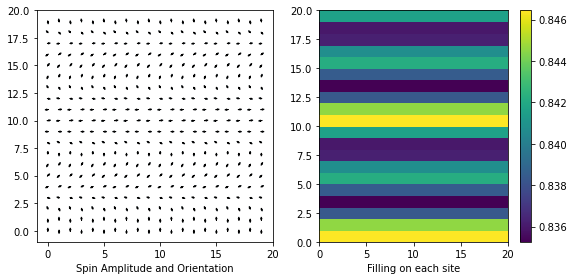

2000 2.5 335.99999999999966
7.683864934637796e-05
0.14022121787460695


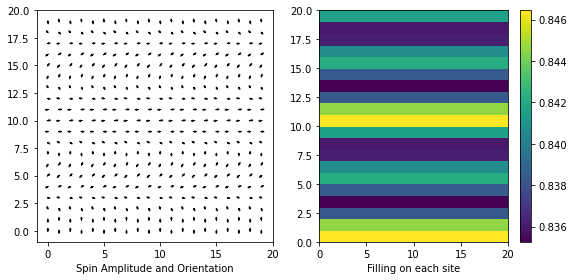

2100 2.5 336.0
9.732299094777908e-05
0.14022121820056171


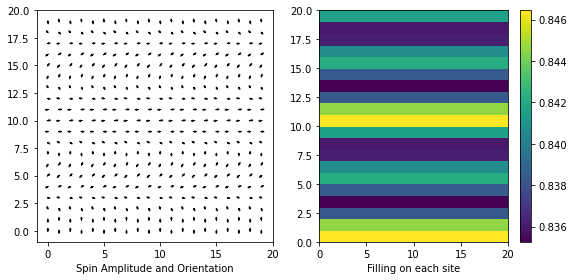

2200 2.5 336.0000000000003
0.00012353880000937068
0.1402212185823779


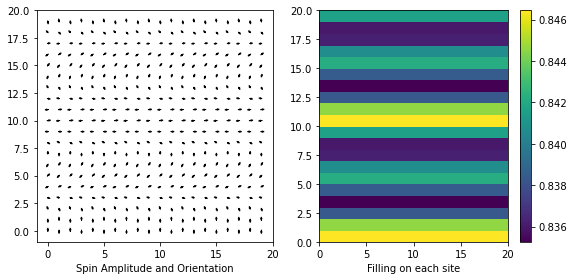

2300 2.5 336.00000000000034
0.00015614133893371296
0.140221219038291


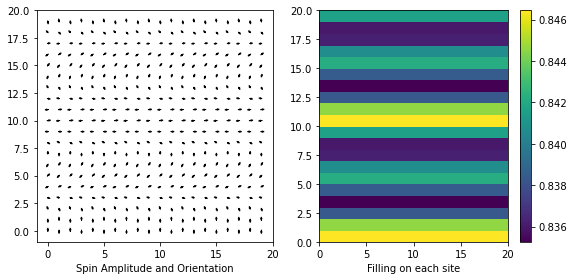

2400 2.5 335.99999999999994
0.00019746993209035502
0.14022121962188203


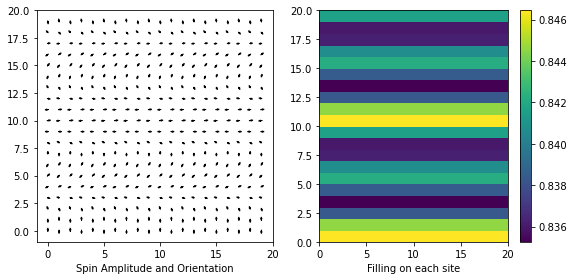

2500 2.5 335.9999999999999
0.00025188561543276755
0.14022122043775373


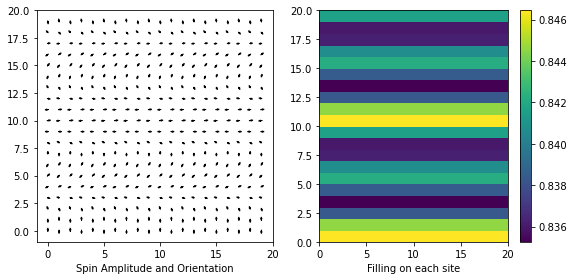

2600 2.5 336.0
0.0003208173107402956
0.14022122158646266


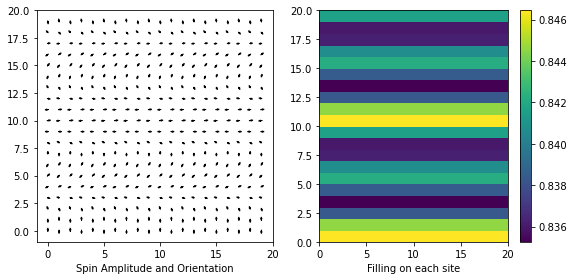

2700 2.5 336.0000000000002
0.0004043822584018919
0.14022122318512362


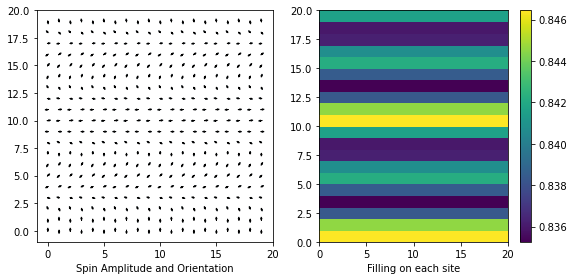

2800 2.5 335.99999999999983
0.0005062708868355248
0.14022122546830867


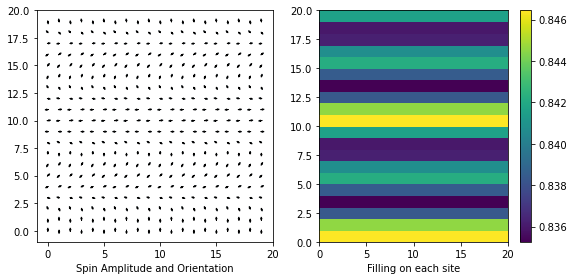

2900 2.5 336.0000000000002
0.0006362538957545016
0.1402212289391978


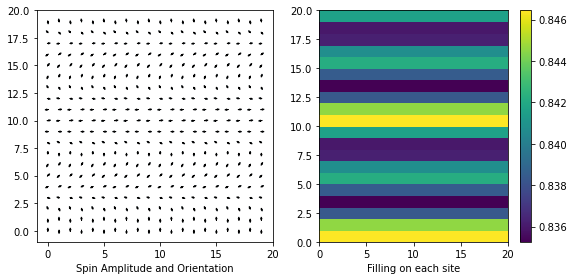

3000 2.5 335.99999999999966
0.0008002557712378788
0.1402212342324263


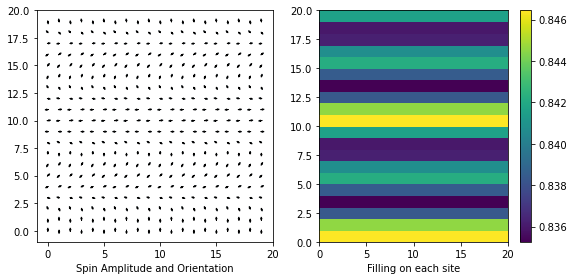

3100 2.5 336.0000000000001
0.0010118243257035697
0.14022124258297153


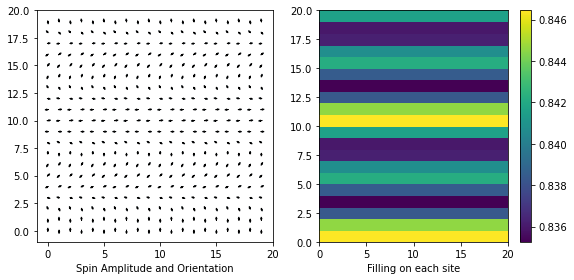

3200 2.5 336.0000000000005
0.0012749161206886406
0.140221255364478


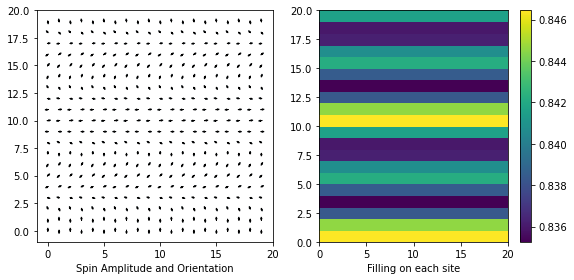

3300 2.5 335.99999999999983
0.0015943060647527485
0.14022127444370588


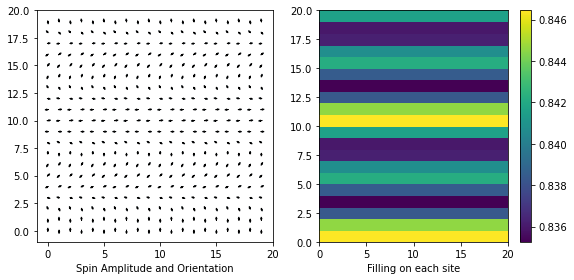

3400 2.5 335.9999999999999
0.002022073211376041
0.14022130608363473


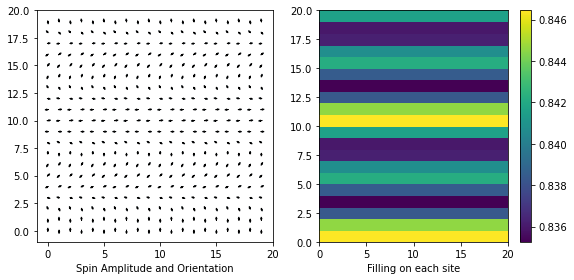

3500 2.5 335.9999999999998
0.0025366294536992573
0.1402213533085841


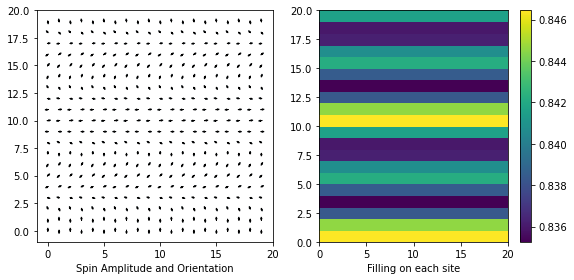

3600 2.5 336.00000000000034
0.00317800348811903
0.14022142607505902


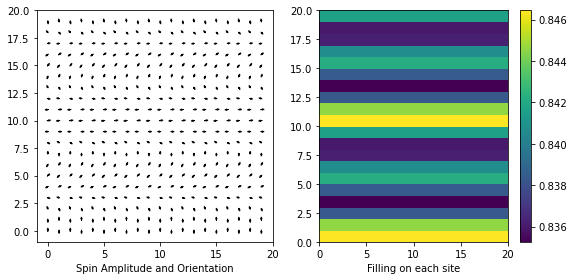

3700 2.5 336.00000000000017
0.004000442134065585
0.14022154176422771


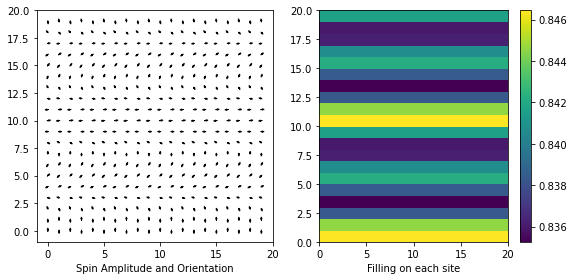

3800 2.5 336.00000000000057
0.005031709348422453
0.14022172204562353


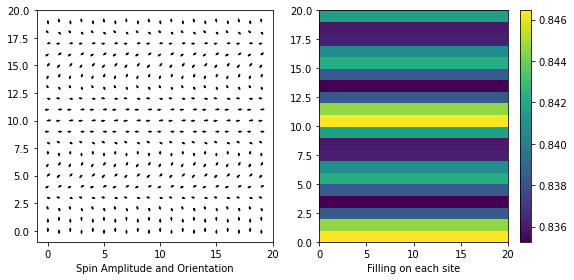

3900 2.5 336.0
0.006370404464584034
0.14022201399467402


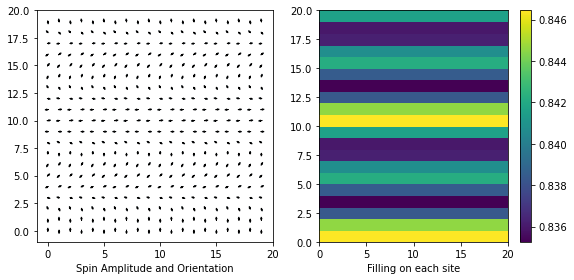

4000 2.5 335.9999999999997
0.008054258076862775
0.1402224733057663


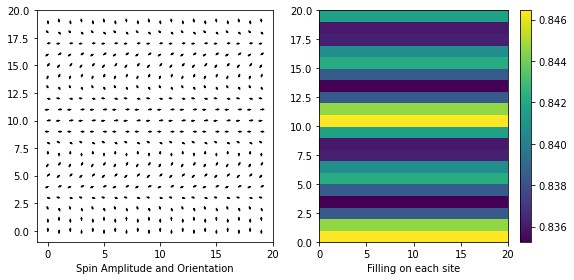

4100 2.5 335.9999999999998
0.010144805900375253
0.14022318500942788


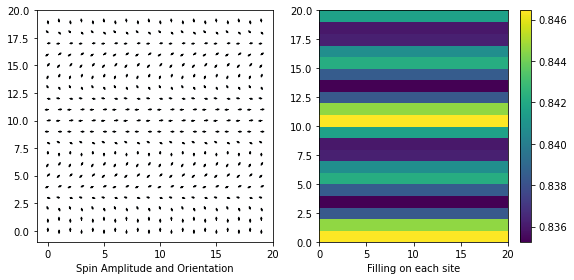

4200 2.5 335.99999999999966
0.012721963563516958
0.14022427617069574


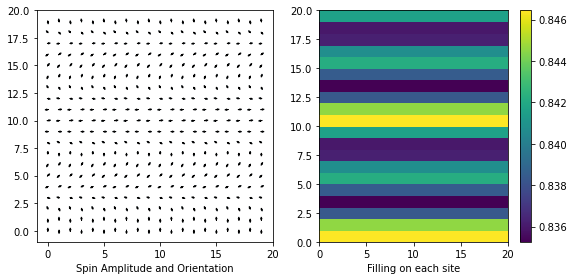

4300 2.5 335.99999999999983
0.016049012778395433
0.14022603092176214


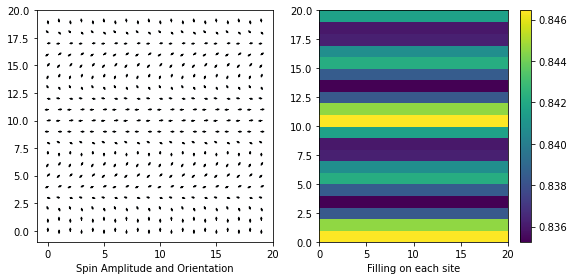

4400 2.5 336.0000000000003
0.020056123563333195
0.14022865748003435


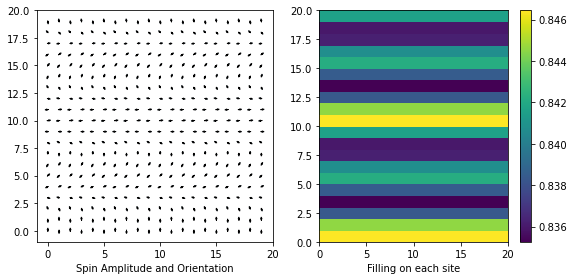

4500 2.5 336.0000000000002
0.025203190649895957
0.14023284685935114


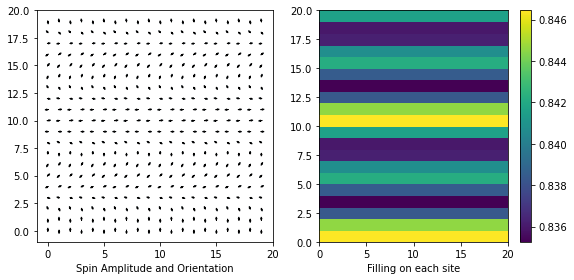

4600 2.5 336.0000000000004
0.03172750500573618
0.14023946253213515


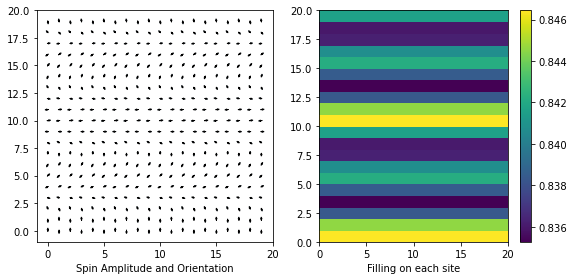

4700 2.5 336.0000000000003
0.03985967400547197
0.1402497309587651


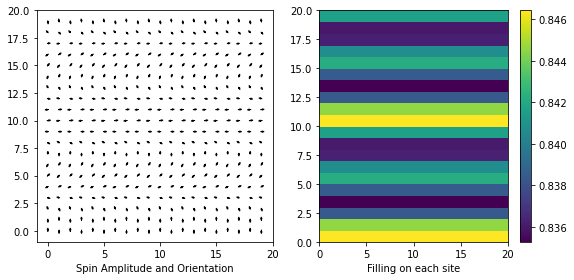

4800 2.5 336.00000000000057
0.05001941712042668
0.14026567507286067


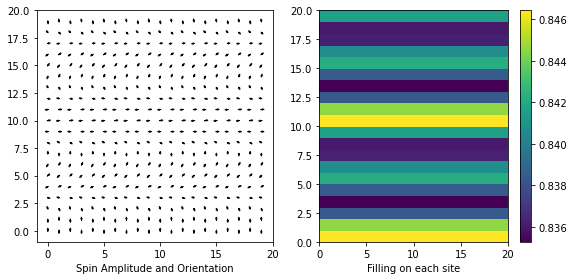

4900 2.5 335.99999999999994
0.06282580983182418
0.1402906340063533


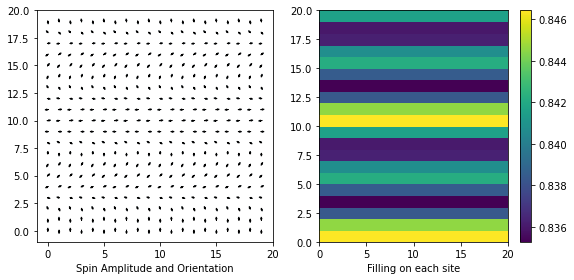

5000 2.5 336.0
0.07862108013890956
0.14032875277790255


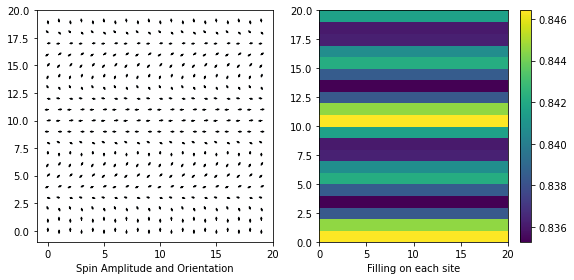

5100 2.5 335.9999999999998
0.09857599786797255
0.14038822205779827


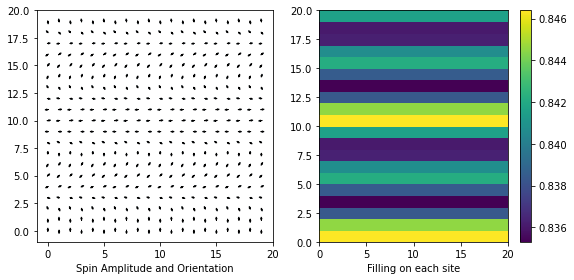

5200 2.5 336.00000000000017
0.12335542489633666
0.14047908523798192


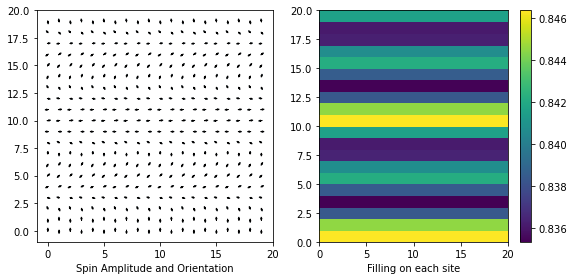

5300 2.5 336.00000000000006
0.15334081616323214
0.14061312530124936


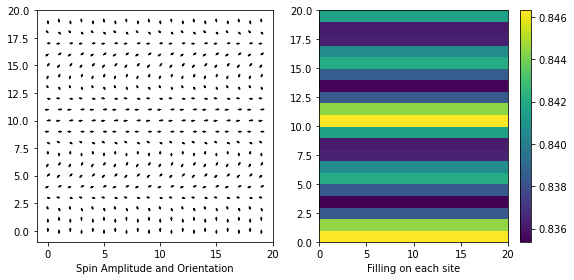

5400 2.5 336.00000000000006
0.19036806352752889
0.14081278215431045


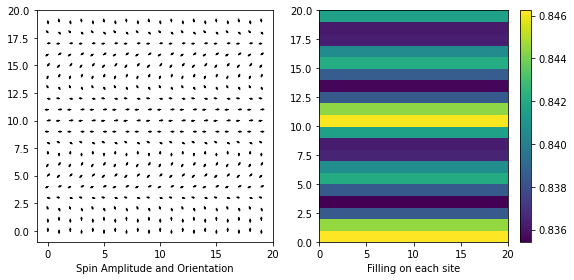

5500 2.5 336.00000000000057
0.23566891198014384
0.14110382964057744


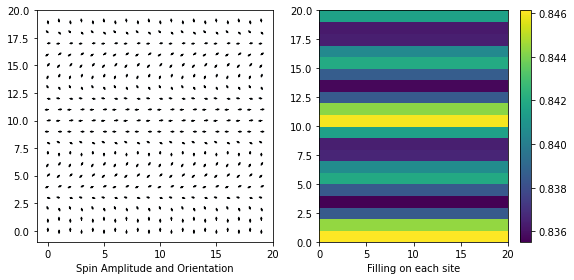

5600 2.5 335.99999999999994
0.28825288526116344
0.14149827106531718


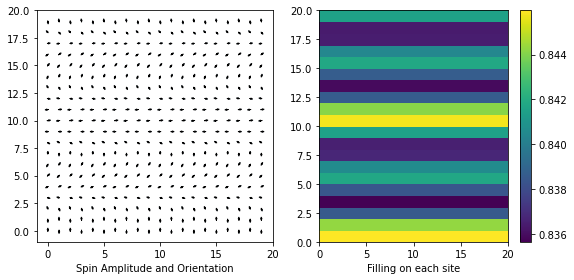

5700 2.5 335.99999999999994
0.3500128699633087
0.14202589945072652


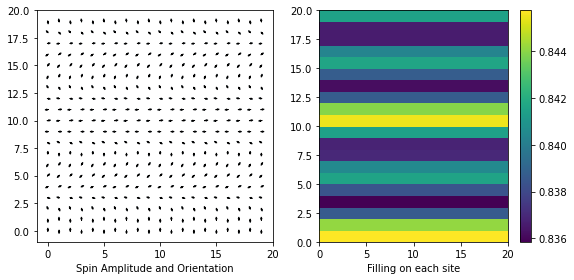

5800 2.5 336.0000000000001
0.4169438086665691
0.14265761259899842


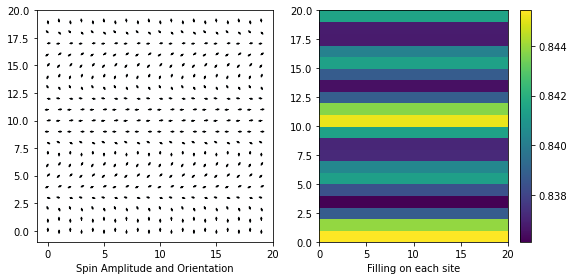

5900 2.5 335.9999999999997
0.48594363343560554
0.14335222109165785


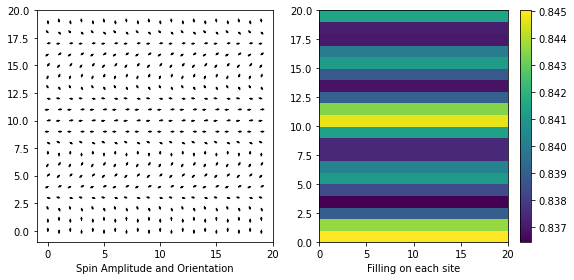

6000 2.5 336.0000000000006
0.5540864796545097
0.14405888545945886


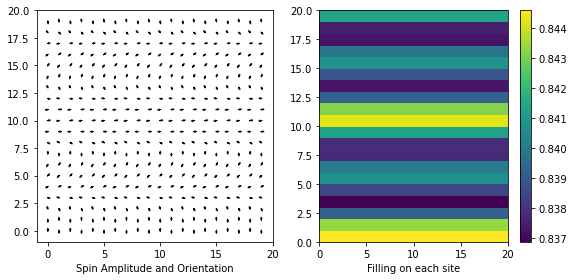

6100 2.5 336.00000000000074
0.6166348137437749
0.14470551595565082


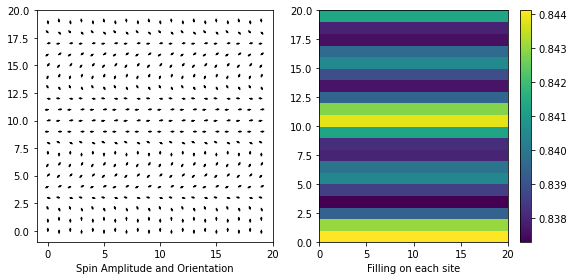

6200 2.5 335.99999999999983
0.673236482164826
0.1452723498531268


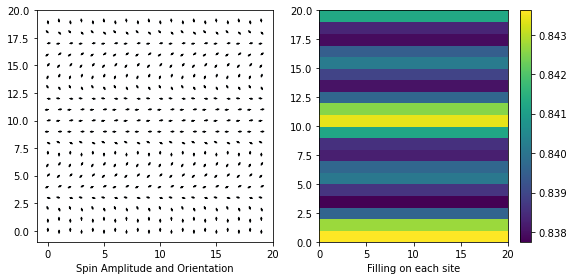

6300 2.5 336.00000000000034
0.7200736238983065
0.14571678928054227


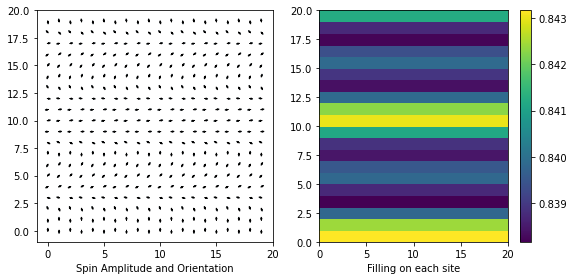

6400 2.5 336.00000000000006
0.7577420427013903
0.1460514126065129


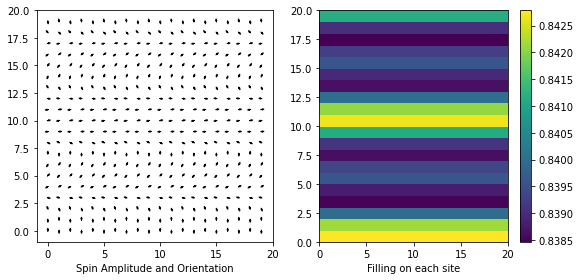

6500 2.5 336.0000000000002
0.7868063839851702
0.14629257727864764


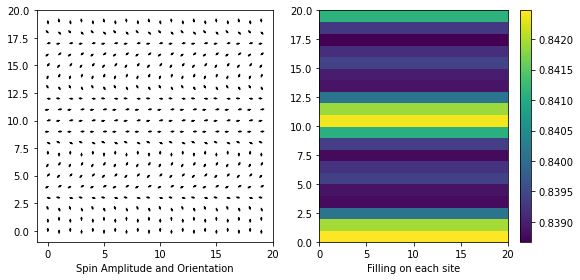

6600 2.5 336.0000000000002
0.8091302722690807
0.14646659992819827


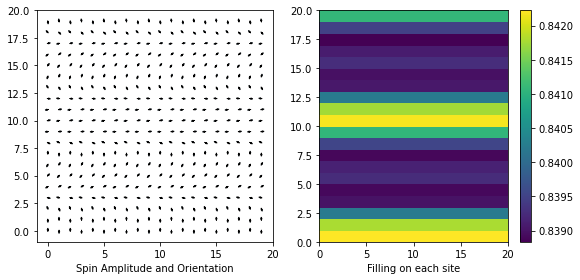

6700 2.5 336.0000000000003
0.8257703315815617
0.146589799311251


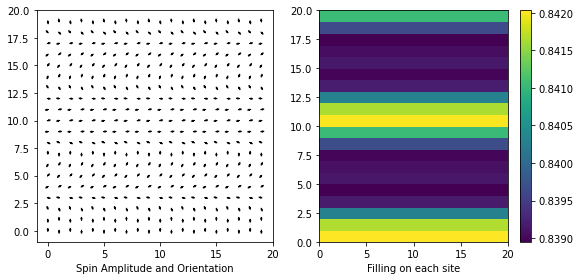

6800 2.5 336.0
0.8383040478002206
0.1466791126788622


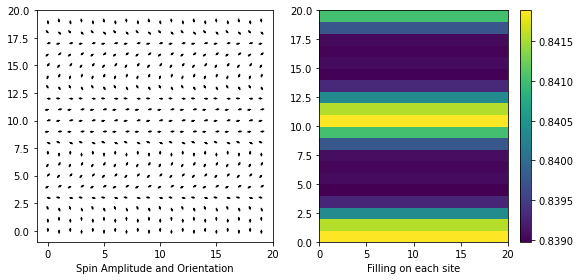

6900 2.5 336.00000000000017
0.8474051276475589
0.14674236007062041


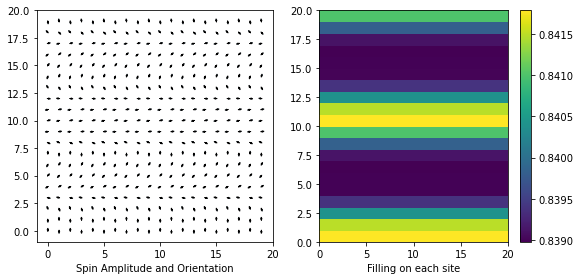

7000 2.5 336.0000000000006
0.8542951759417186
0.14678960073298986


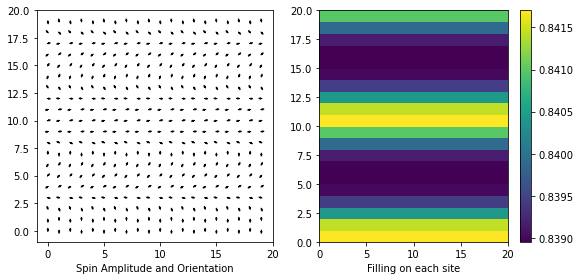

7100 2.5 336.00000000000006
0.8593406744433874
0.14682404408195612


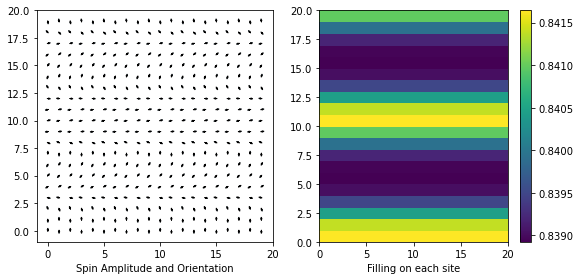

7200 2.5 336.00000000000006
0.8630471837413434
0.14684941023474435


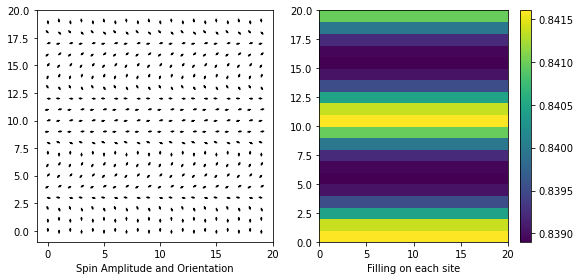

7300 2.5 336.0
0.8658436630023085
0.14686868740776815


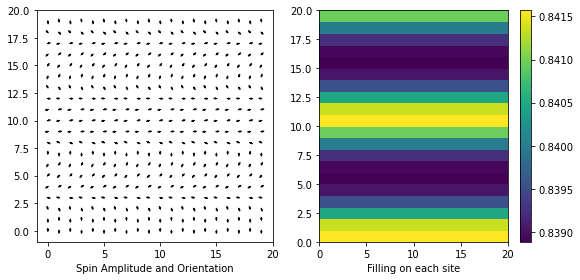

7400 2.5 336.0000000000001
0.8679190289783953
0.14688314275298692


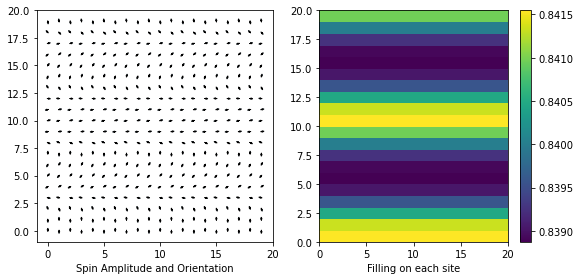

7500 2.5 336.00000000000017
0.8694856659496746
0.1468941893026262


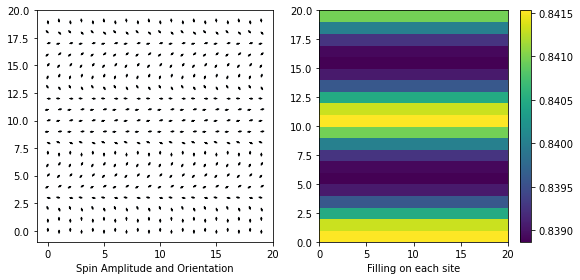

7600 2.5 336.0000000000001
0.8706146233016563
0.14690225424076644


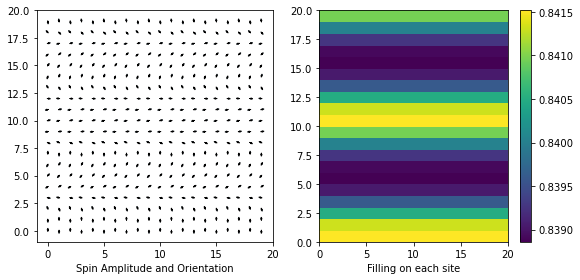

7700 2.5 336.0000000000003
0.8714725586787986
0.14690846380323289


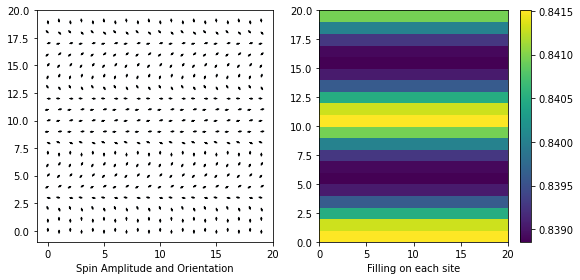

7800 2.5 336.00000000000017
0.8721048760402415
0.14691309963042684


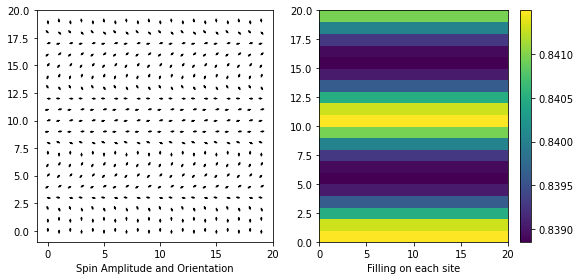

7900 2.5 336.0000000000002
0.872584873336665
0.14691666227251726


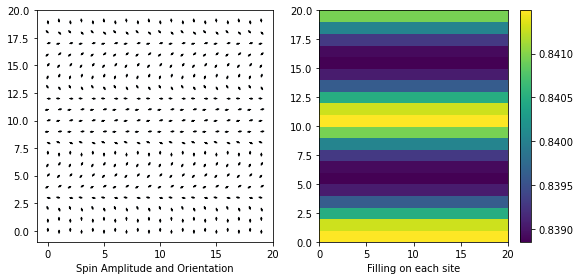

8000 2.5 336.0000000000005
0.8729511609986895
0.1469194132041578


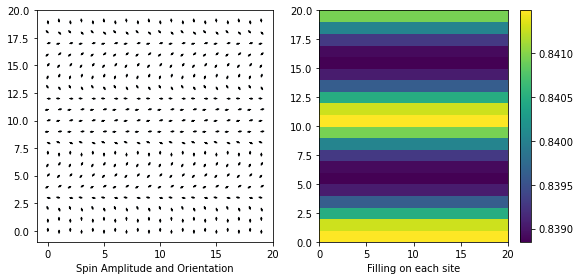

8100 2.5 336.0000000000001
0.8732221533227102
0.1469214711311549


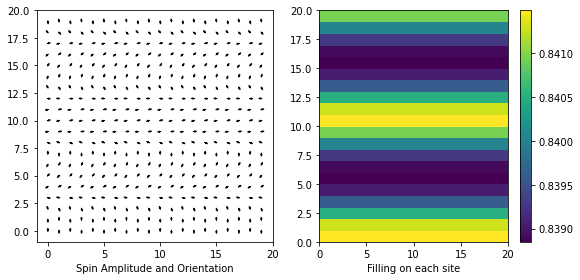

8200 2.5 335.9999999999998
0.873419330284682
0.14692298364680462


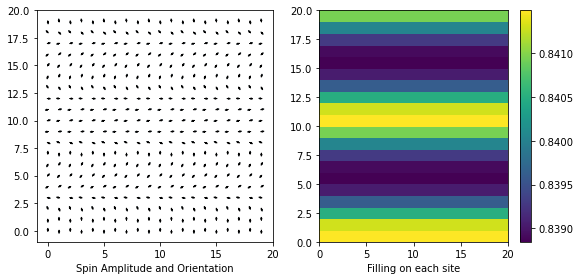

8300 2.5 335.9999999999997
0.8735703312392138
0.14692415261583794


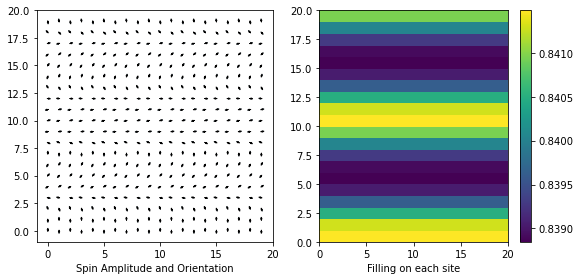

8400 2.5 336.0000000000003
0.8736837839350504
0.1469250383770219


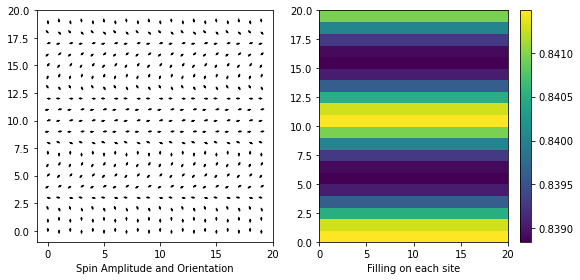

8500 2.5 336.0000000000001
0.8737698636984219
0.14692571566672746


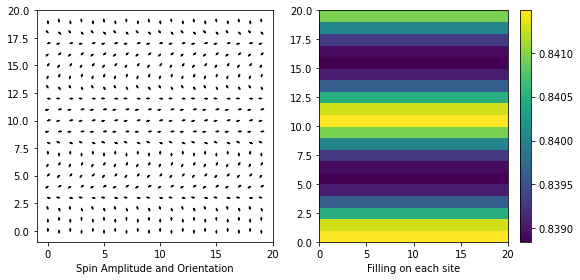

8600 2.5 335.99999999999994
0.8738326363158708
0.14692621304773554


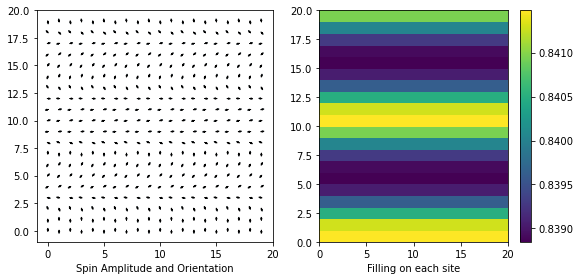

8700 2.5 335.99999999999983
0.873878639411461
0.14692657981371904


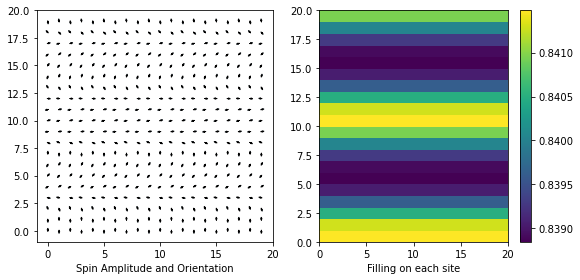

8800 2.5 336.00000000000017
0.8739139373960039
0.14692686279547307


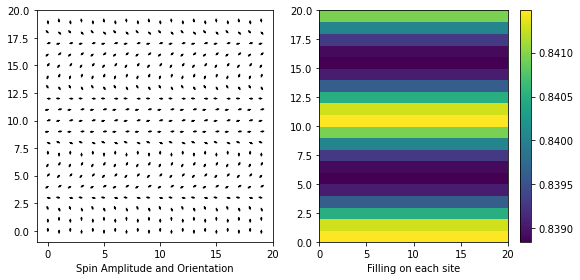

8900 2.5 336.0000000000002
0.873940092095193
0.14692707352994155


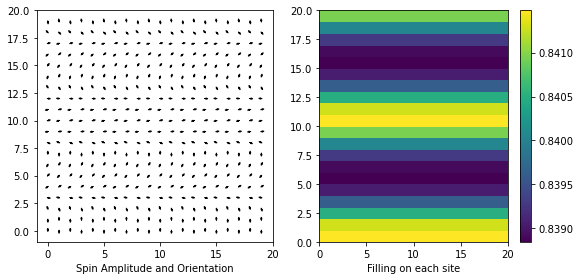

9000 2.5 335.9999999999997
0.8739600390730105
0.1469272349723941


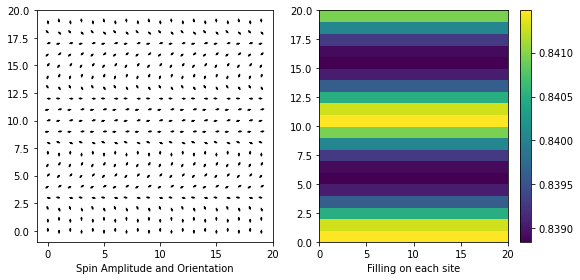

9100 2.5 335.99999999999915
0.8739749731317894
0.14692735633558335


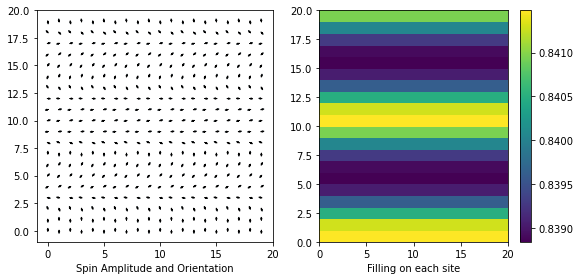

9200 2.5 335.99999999999966
0.8739858697096139
0.1469274452072535


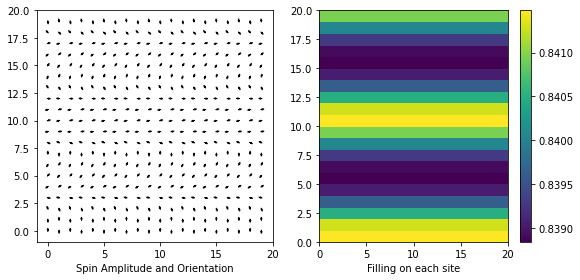

9300 2.5 335.9999999999995
0.8739942839969119
0.14692751405426832


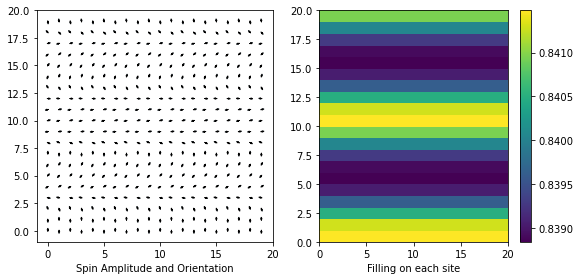

9400 2.5 336.0000000000006
0.8740005909475519
0.1469275658095409


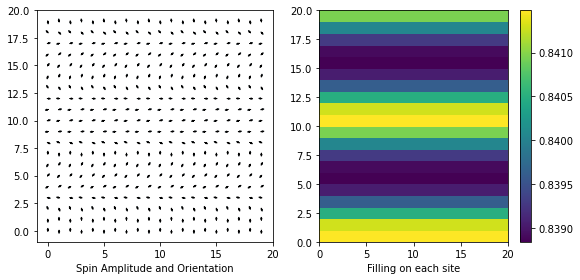

9500 2.5 336.00000000000114
0.874005197368382
0.14692760370778704


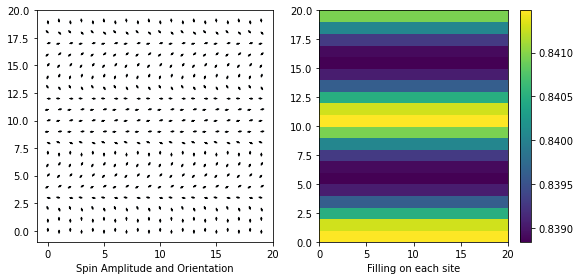

9600 2.5 336.0000000000011
0.8740086619135905
0.1469276322763069


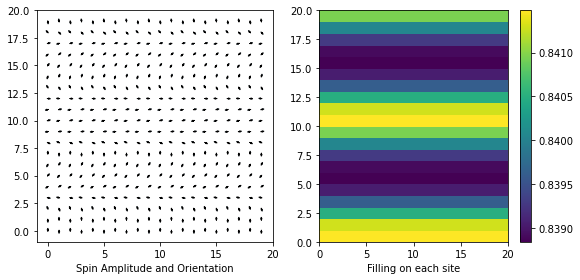

9700 2.5 336.00000000000085
0.8740112684161776
0.1469276538130732


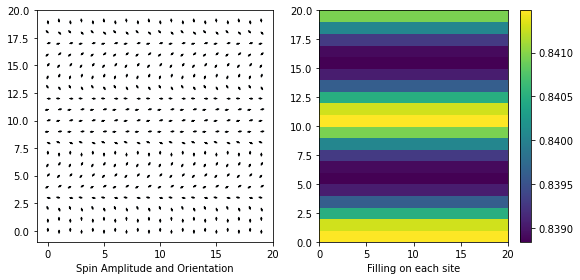

9800 2.5 336.00000000000125
0.8740132258134841
0.14692767001577395


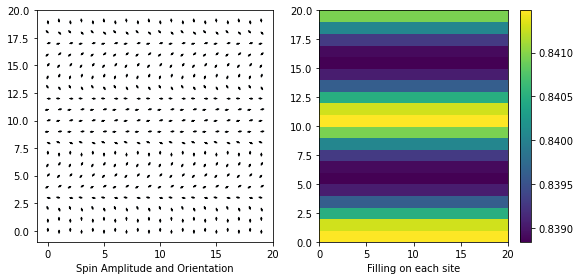

9900 2.5 336.00000000000034
0.8740147112923808
0.14692768233203757


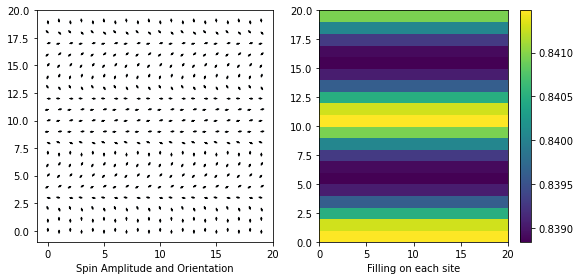

10000 2.5 335.9999999999996
0.8740158358978691
0.14692769166988665


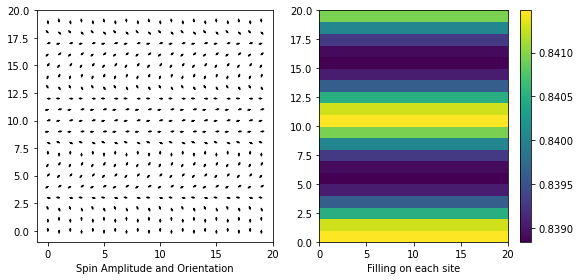

10100 2.5 336.0000000000017
0.8740166624550736
0.1469276985418836


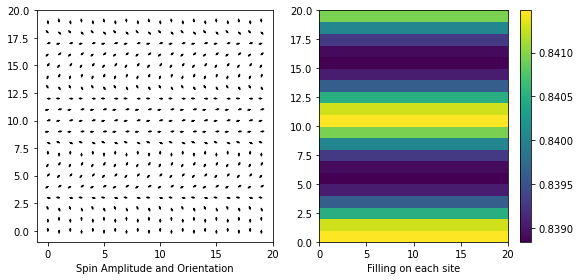

10200 2.5 335.9999999999995
0.874017294785717
0.14692770380514503


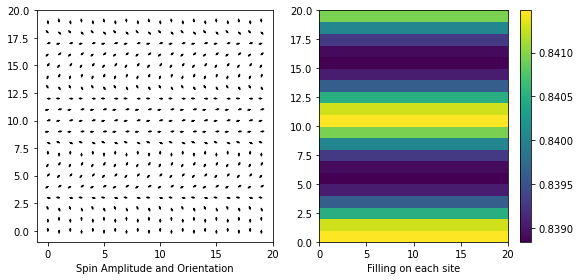

10300 2.5 336.0000000000006
0.874017754410723
0.14692770763479301


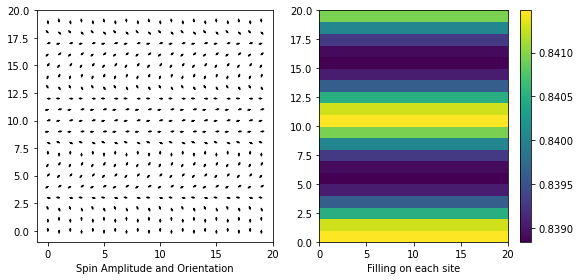

10400 2.5 336.0000000000005
0.8740181104459195
0.14692771060401222


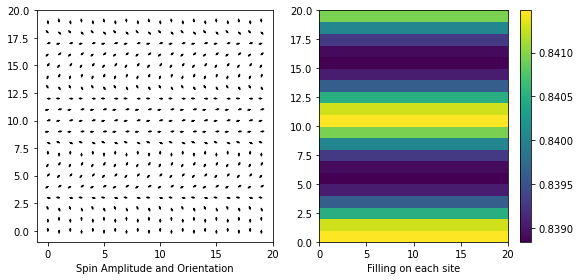

10500 2.5 336.00000000000057
0.8740183745621302
0.1469277128084603


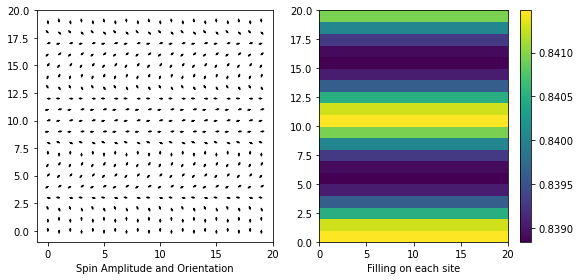

10600 2.5 336.00000000000034
0.8740185765695774
0.1469277144957491


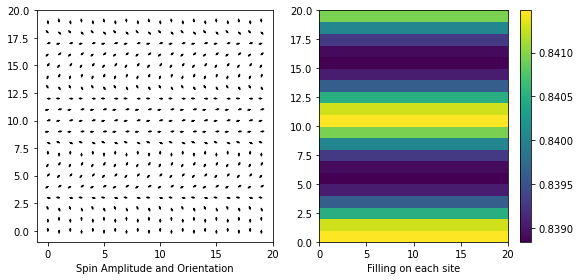

10700 2.5 335.9999999999999
0.8740187285462477
0.14692771576598937


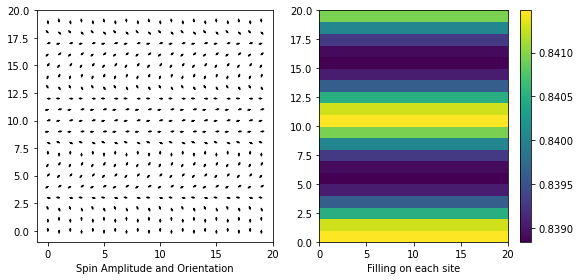

10800 2.5 335.99999999999955
0.8740188382266236
0.1469277166832432


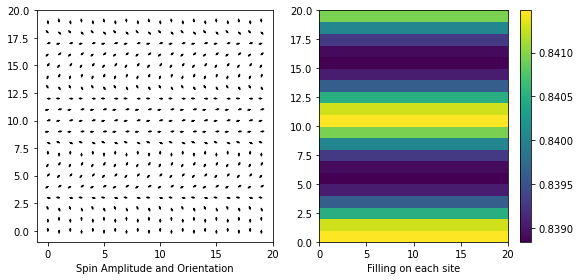

10900 2.5 335.9999999999995
0.8740189231086166
0.1469277173934735


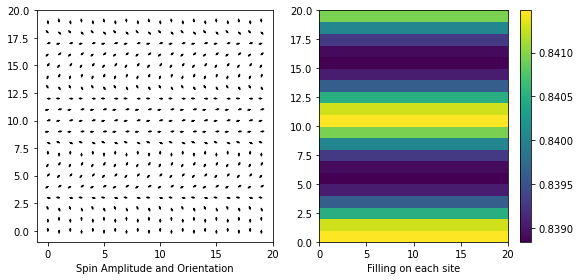

11000 2.5 336.00000000000034
0.8740189849659861
0.14692771791128853


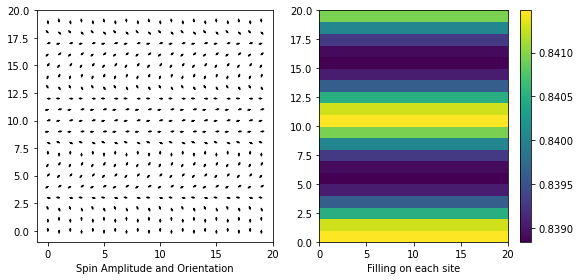

11100 2.5 335.9999999999996
0.874019031268114
0.14692771829904436


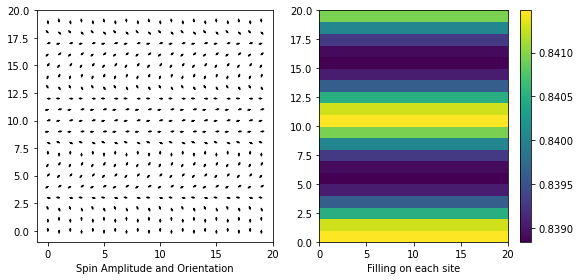

11200 2.5 336.00000000000074
0.8740190670769894
0.1469277185990337


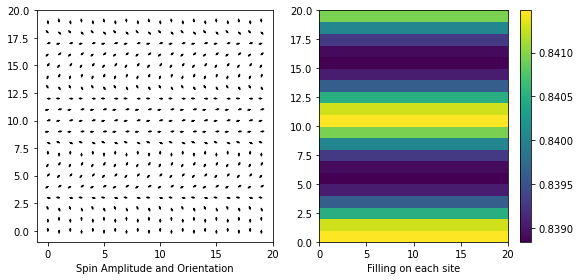

11300 2.5 336.0000000000003
0.8740190934458103
0.14692771882001057


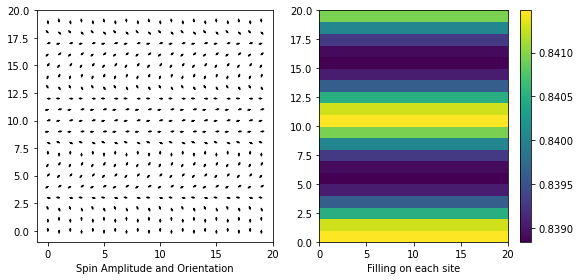

11400 2.5 335.9999999999991
0.8740191134632793
0.14692771898780993


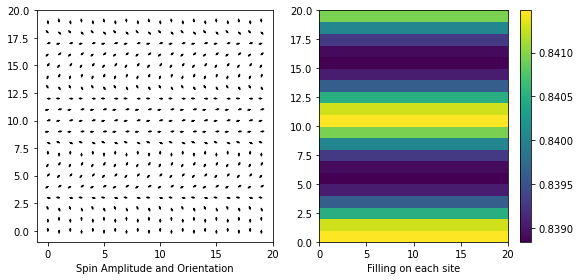

11500 2.5 335.9999999999989
0.874019128381486
0.14692771911289668


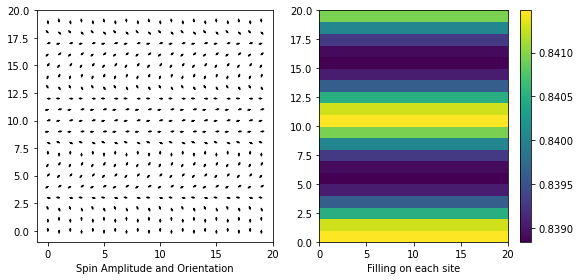

11600 2.5 336.0000000000004
0.8740191392565015
0.14692771920410252


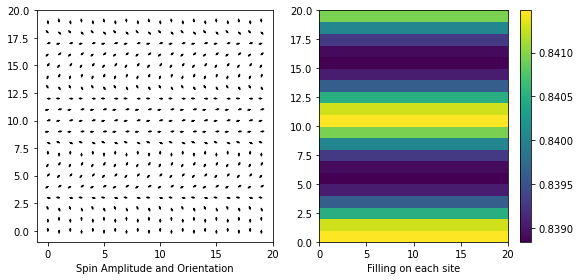

11700 2.5 336.000000000001
0.8740191474117687
0.14692771927251205


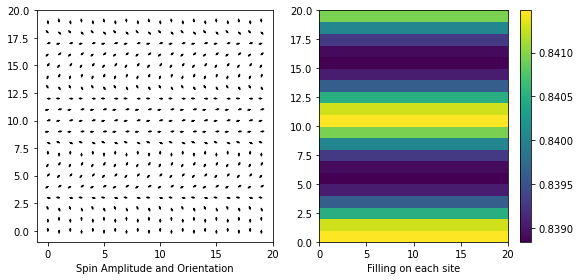

11800 2.5 335.99999999999983
0.8740191535552069
0.1469277193240546


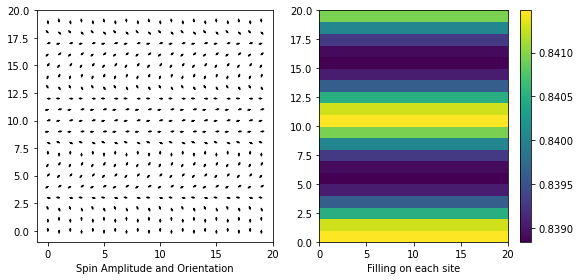

11900 2.5 335.9999999999991
0.874019158116222
0.14692771936232696


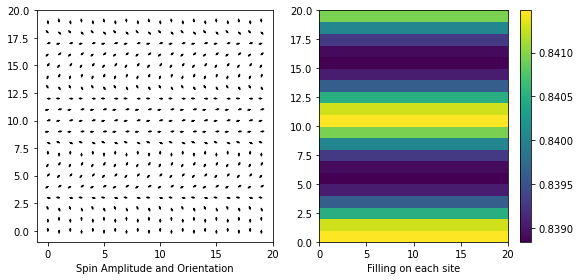

12000 2.5 335.9999999999997
0.8740191616323378
0.14692771939183533


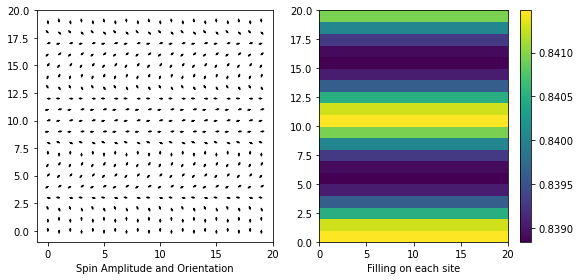

12100 2.5 336.0000000000003
0.8740191642541566
0.14692771941384128


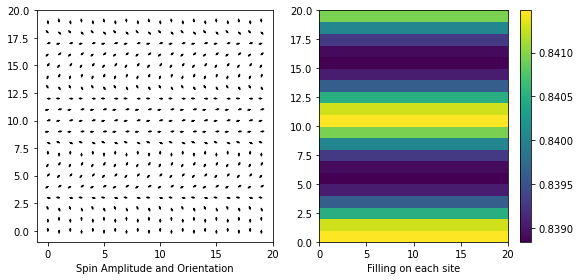

12200 2.5 335.99999999999875
0.8740191662496226
0.1469277194305919


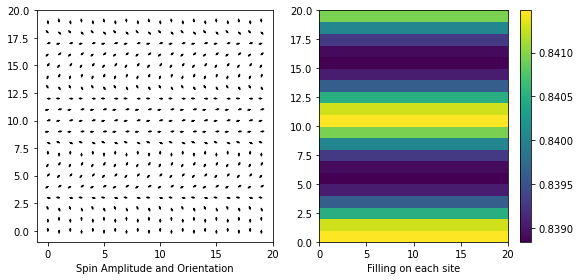

12300 2.5 335.99999999999915
0.8740191677294122
0.14692771944301458


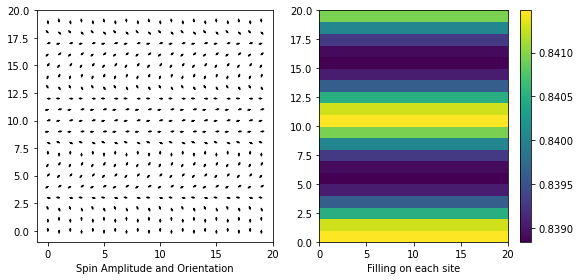

12400 2.5 335.9999999999992
0.874019168844884
0.14692771945238006


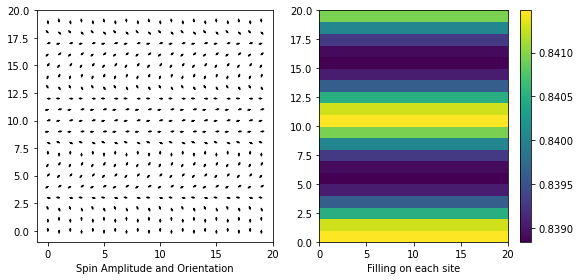

12500 2.5 336.0000000000005
0.8740191696882151
0.14692771945946081


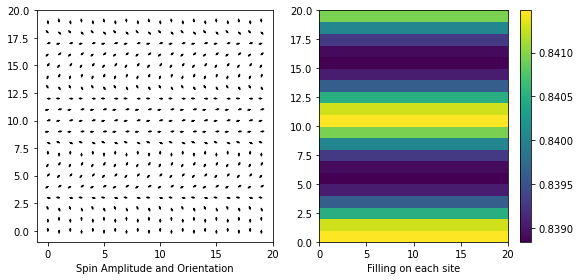

12600 2.5 336.0000000000006
0.8740191703273554
0.14692771946482772


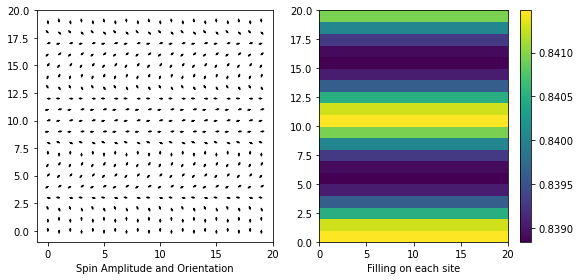

12700 2.5 336.0000000000004
0.874019170796124
0.1469277194687639


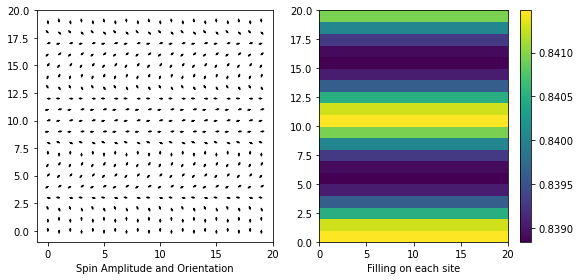

12800 2.5 335.99999999999915
0.8740191711435834
0.14692771947168157


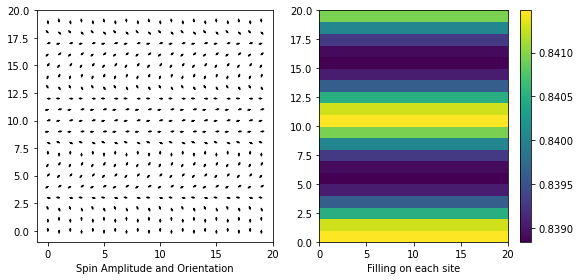

12900 2.5 335.99999999999903
0.8740191714094077
0.1469277194739143


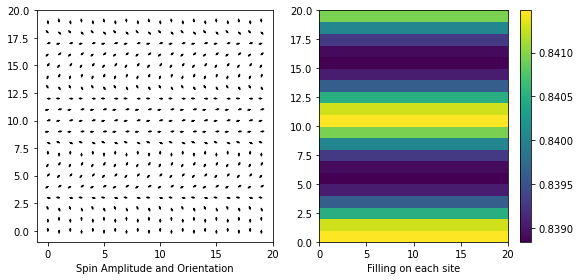

13000 2.5 335.9999999999985
0.8740191716173875
0.14692771947566097


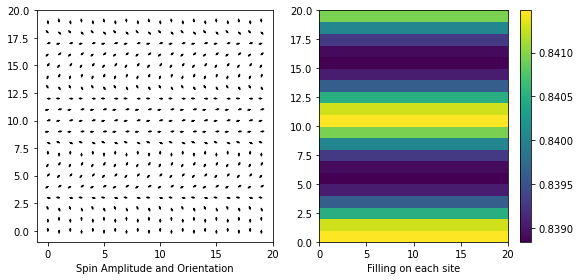

13100 2.5 336.00000000000006
0.8740191717675119
0.14692771947692163


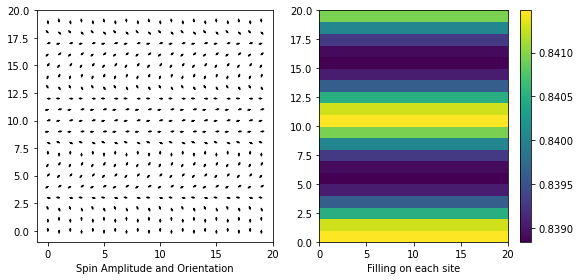

13200 2.5 335.9999999999986
0.8740191718835568
0.1469277194778962


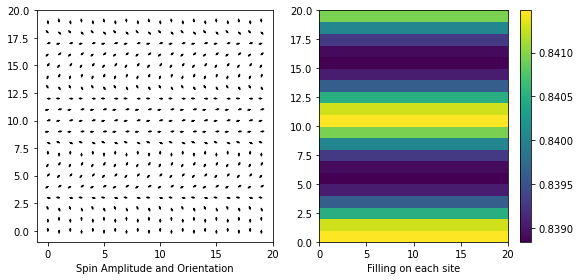

13300 2.5 336.00000000000006
0.8740191719701462
0.14692771947862351


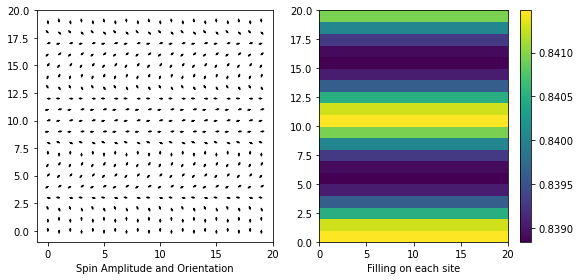

13400 2.5 336.0
0.8740191720340516
0.14692771947915964


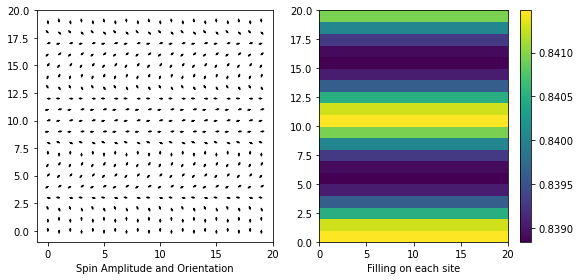

13500 2.5 336.00000000000017
0.8740191720824475
0.14692771947956632


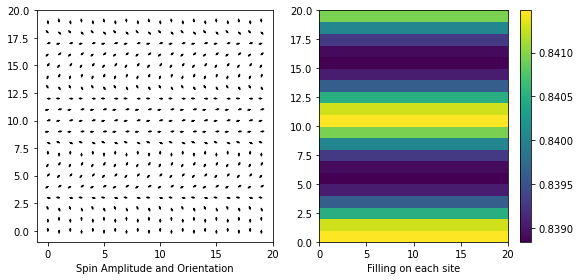

13600 2.5 336.000000000001
0.8740191721178663
0.14692771947986352


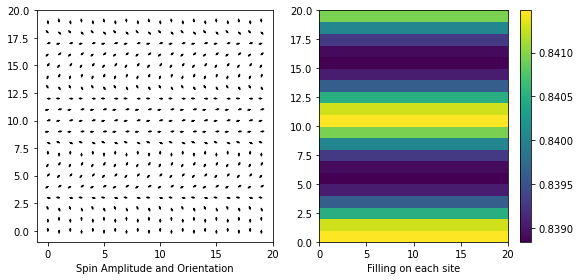

13700 2.5 336.0
0.8740191721459523
0.14692771948009928


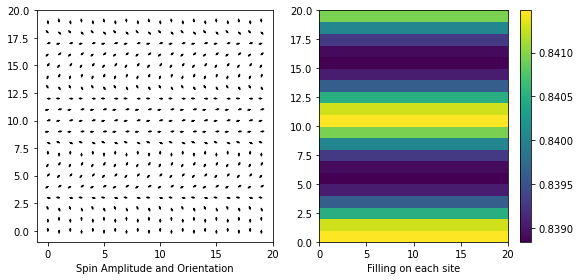

13800 2.5 335.99999999999943
0.8740191721666619
0.14692771948027314


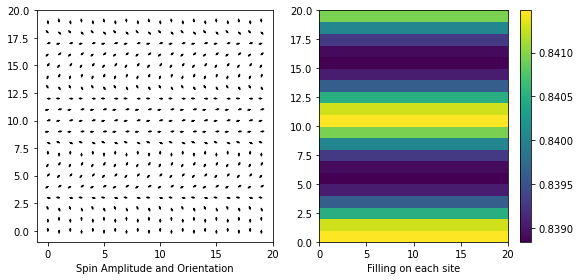

13900 2.5 336.0000000000008
0.8740191721820816
0.14692771948040118


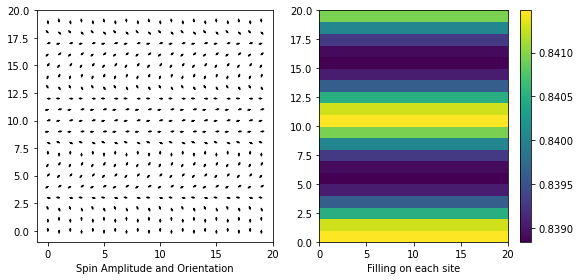

14000 2.5 336.0000000000005
0.8740191721938229
0.14692771948050065


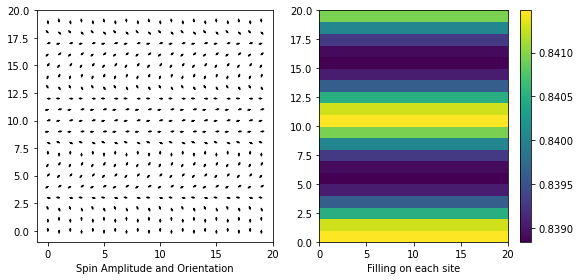

14100 2.5 336.0000000000009
0.8740191722023507
0.14692771948057218


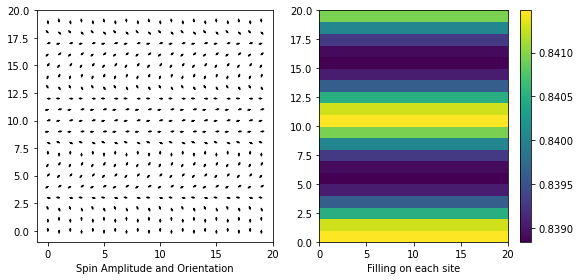

14200 2.5 336.00000000000085
0.8740191722089108
0.14692771948062705


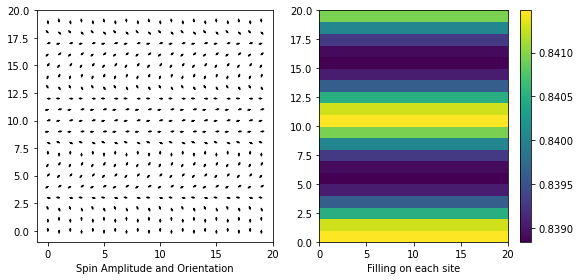

14300 2.5 336.0000000000008
0.8740191722137398
0.14692771948066752


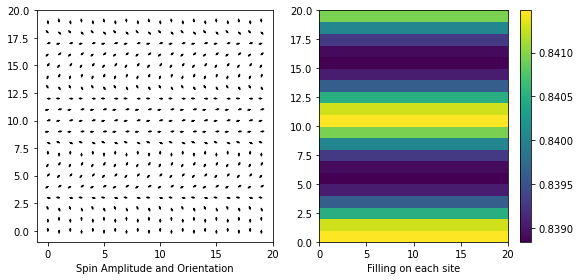

14400 2.5 335.9999999999992
0.8740191722174302
0.14692771948069835


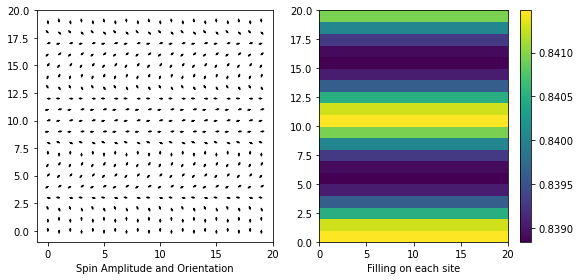

14500 2.5 336.00000000000097
0.8740191722201915
0.14692771948072134


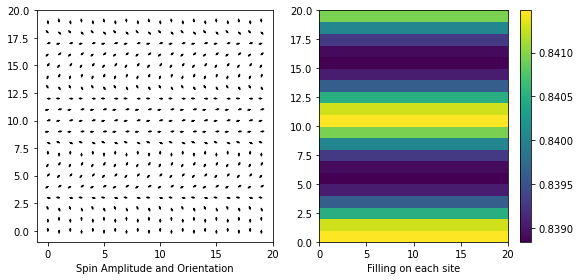

14600 2.5 335.99999999999966
0.8740191722223356
0.14692771948073885


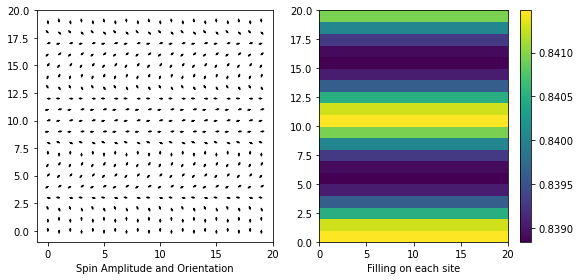

14700 2.5 336.00000000000034
0.874019172223921
0.14692771948075212


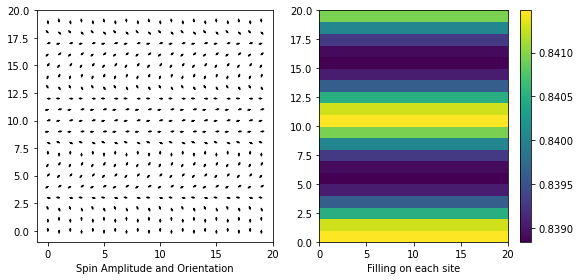

14800 2.5 336.00000000000085
0.87401917222512
0.14692771948076186


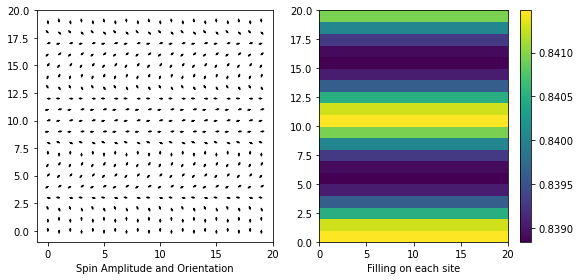

14900 2.5 335.9999999999999
0.8740191722260242
0.14692771948076955


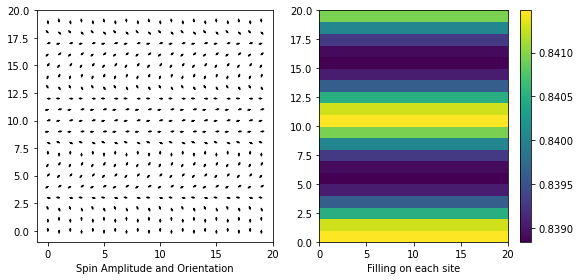

15000 2.5 336.00000000000045
0.8740191722267507
0.14692771948077504


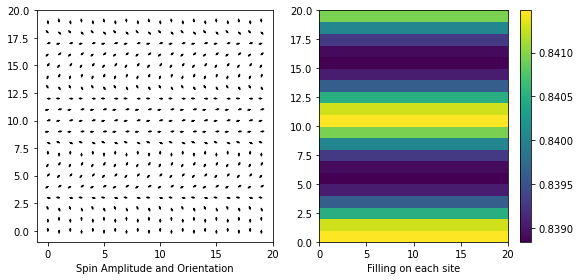

15100 2.5 335.99999999999926
0.8740191722272703
0.14692771948077937


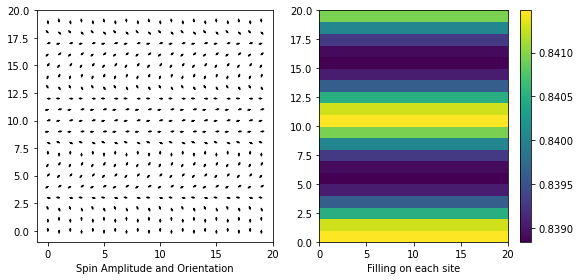

15200 2.5 335.9999999999993
0.8740191722276549
0.1469277194807823


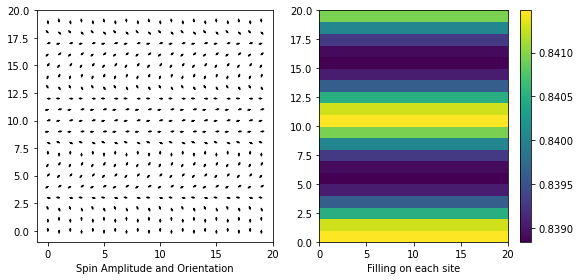

15300 2.5 336.0000000000001
0.8740191722279578
0.1469277194807848


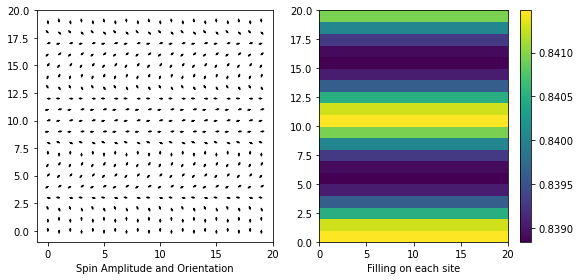

15400 2.5 336.0000000000004
0.8740191722281896
0.1469277194807865


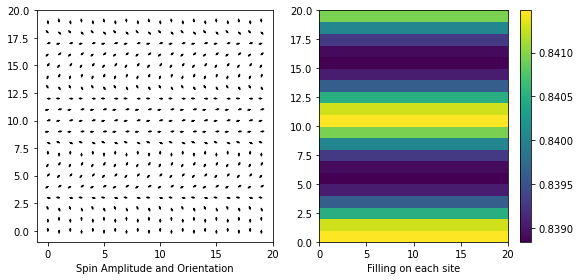

15500 2.5 336.0000000000007
0.8740191722283788
0.14692771948078767


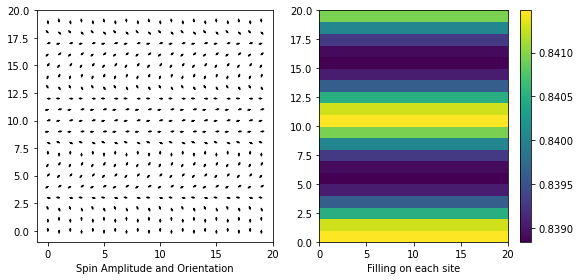

15600 2.5 336.00000000000057
0.8740191722285084
0.14692771948078875


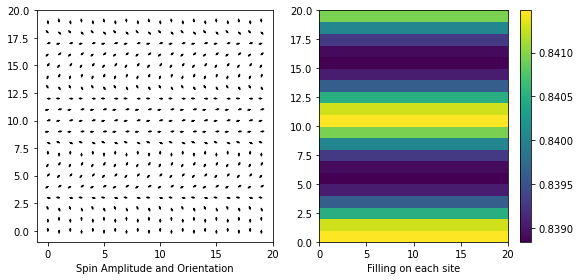

15700 2.5 335.9999999999998
0.8740191722286497
0.1469277194807897


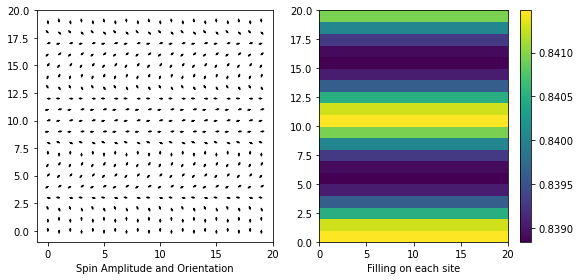

15800 2.5 335.9999999999989
0.8740191722287713
0.14692771948079014


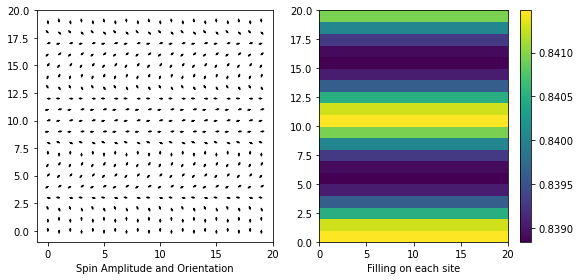

15900 2.5 335.99999999999875
0.8740191722288446
0.1469277194807905


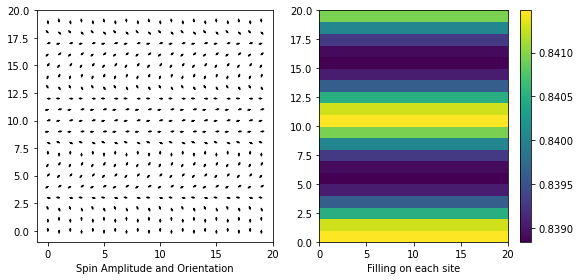

16000 2.5 335.9999999999992
0.8740191722289135
0.14692771948079086


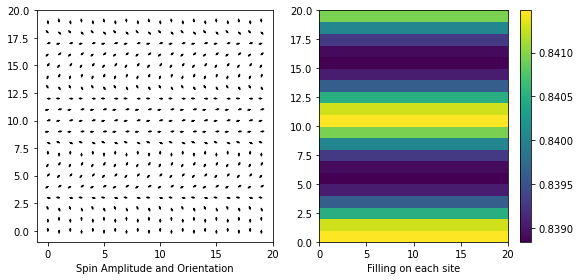

16100 2.5 335.99999999999926
0.874019172228957
0.146927719480791


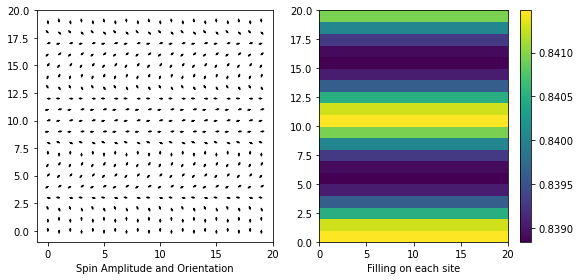

16200 2.5 335.9999999999988
0.8740191722290294
0.14692771948079122


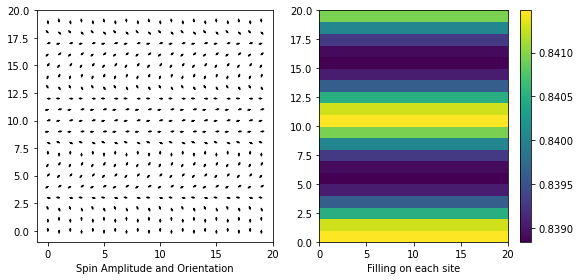

16300 2.5 335.9999999999987
0.8740191722290813
0.14692771948079134


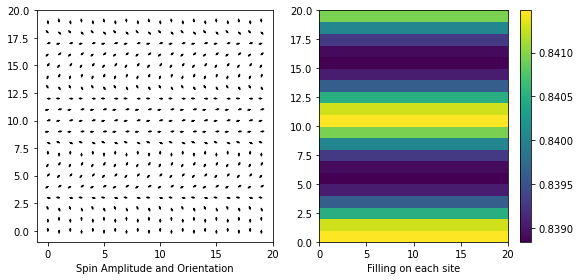

16400 2.5 335.99999999999875
0.8740191722290951
0.14692771948079142


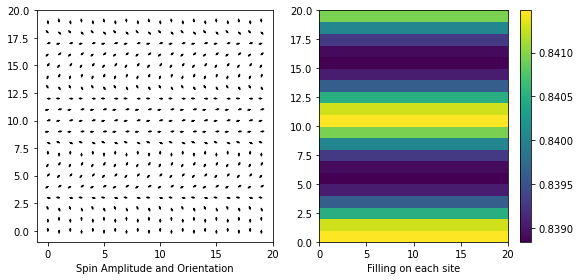

16500 2.5 335.9999999999988
0.8740191722291435
0.14692771948079153


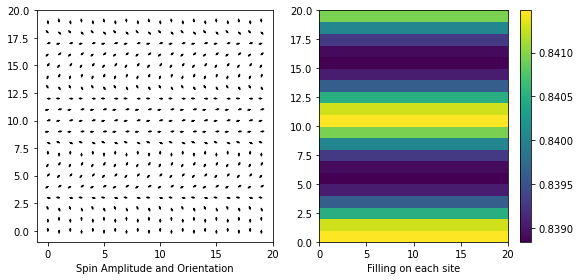

16600 2.5 335.9999999999994
0.8740191722291737
0.14692771948079145


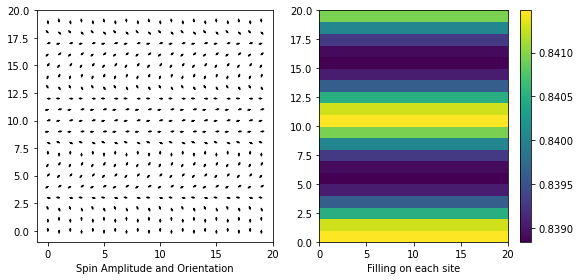

16700 2.5 335.99999999999966
0.8740191722292279
0.14692771948079167


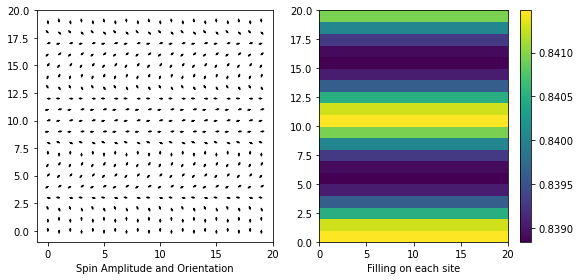

16800 2.5 336.0000000000003
0.8740191722292052
0.14692771948079164


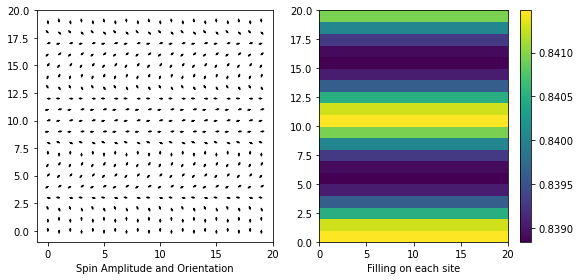

KeyboardInterrupt: 

In [65]:
###If one wants to access the energies for each iteration.

RandVec = np.random.random(N_tot)

RandVec2 = RandVec # =RandVec, if we want to enforce the polarization plane to lie in x-y-plane.

#GapVector = np.append(RandVec,np.append(RandVec2,np.random.random(2*N_tot)-0.5))
#mus2 = []
#Energies2 = []
#GapVector = np.load("GapVector_Nx{}_Ny{}_U{}_Doping{}_OneBandModel_Iteration{}_tprime{}_Periodicx{}_Periodicy{}_Temperature{}.npy".format(N_x,N_y,U,Doping,2000,np.abs(t_prime),Periodic_Boundaries_x,Periodic_Boundaries_y,T))
for i in range(100000):
    if(i%100 == 0 or i == 20):
        print(i,U,sum(GapVector[:2*N_tot]))
        Plot_Arrows(GapVector)
    NewGapVector,Energy,mu_new = Next_Gap_Vector(GapVector,GetEnergy = True,ReturnThree = True)
    Energies.append(Energy)
    mus.append(mu_new)
    Mixing = 0.4*np.random.random()
    GapVector = Mixing*GapVector + (1-Mixing)*NewGapVector


In [ ]:
Spectral,Shift = Next_Gap_Vector(GapVector,GetEnergy = True,ReturnSpectral = True)
#print(Spectral-Shift)
plt.hist(Spectral-Shift,bins = 46)
plt.show()


In [46]:
H = Get_H(GapVector,H_0)
epsilons, Eigenvectors = sp.linalg.eigh(H)
N_filled = int(N_tot*n_filling) 
ChemPot = (epsilons[N_filled]+epsilons[N_filled-1])/2.
M= Eigenvectors
BigM = Exp_Val_Matrix(Eigenvectors,epsilons,ChemPot)

In [47]:
def CorrFunc(i1,i2,i3,i4):
    
    return BigM[i1,i4]*BigM[i2,i3]-BigM[i1,i3]*BigM[i2,i4]

In [48]:
def SpinSpinCorrFuncEqualTime(Spin_Orientation1,Spin_Orientation2,Site_Index_1,Site_Index_2): #e.g. S_1^z S_2^x
    
    #The spin orientations must be passed as a vector, e.g. z corresponds to [0,0,0,1]
    #Actually computes -1/2*(<S1S2>-<S1><S2>)

    #Define Pauli Matrices
    s0 = np.matrix([[1,0],[0,1]])
    s1 = np.matrix([[0,1],[1,0]])
    s2 = np.matrix([[0,-1j],[1j,0]])
    s3 = np.matrix([[1,0],[0,-1]])
    PauliVector = np.array([s0,s1,s2,s3])

    
    Sigma1 = np.matmul(PauliVector.transpose(),np.array(Spin_Orientation1)).transpose()/np.linalg.norm(Spin_Orientation1)
    Sigma2 = np.matmul(PauliVector.transpose(),np.array(Spin_Orientation2)).transpose()/np.linalg.norm(Spin_Orientation2)
    
    
    ExpVal = 0.
    
    for s1 in [0,1]:
        for s2 in [0,1]:
            for s3 in [0,1]:
                for s4 in [0,1]:
                    if(Site_Index_1==Site_Index_2 and s2==s3):
                        ExpVal += Sigma1[s1,s2]*Sigma2[s3,s4]*BigM[Site_Index_1+s1,Site_Index_2+s4]
                    
                    ExpVal -= Sigma1[s1,s2]*Sigma2[s3,s4]*CorrFunc(2*Site_Index_1+s1,2*Site_Index_2+s3,2*Site_Index_1+s2,2*Site_Index_2+s4)
                    ExpVal -= Sigma1[s1,s2]*Sigma2[s3,s4]*BigM[2*Site_Index_1+s1,2*Site_Index_1+s2]*BigM[2*Site_Index_2+s3,2*Site_Index_2+s4]
    return ExpVal

In [49]:
def CorrFuncFrequencyFast(i1,i2,i3,i4,Vectorized = False):
    if(Vectorized == False):
        Summe = -(M[i1,:].conjugate()*M[i4,:])@B@(M[i3,:].conjugate()*M[i2,:])
        return Summe

    Summe = -np.einsum('ji,ji->j',((M[i1,:].conjugate()*M[i4,:])@B),(M[i3,:].conjugate()*M[i2,:]))
    return Summe

In [50]:
def CorrFuncFrequencyFast2(i1,i2,i3,i4,Vectorized = False):
    if(Vectorized == False):
        Summe = -QuickM[i1,i4]@Contracted_M[i3,i2]
        return Summe

    Summe = -np.einsum('ji,ji->j',QuickM[i1,i4],Contracted_M[i3,i2])
    return Summe

In [51]:
def Fill_B(a,b):
    l1 = np.real(a).astype(int)
    l2 = np.real(b).astype(int)

    return (n_occ(epsilons[l1],ChemPot)-n_occ(epsilons[l2],ChemPot))/(epsilons[l1] -epsilons[l2]+1j*Omega)


def Fill_B_Omega0(a,b):
    l1 = np.real(a).astype(int)
    l2 = np.real(b).astype(int)
    
    return np.where(np.isclose(epsilons[l1],epsilons[l2]),-beta*np.exp(beta*(epsilons[l1]-ChemPot))/(np.exp(beta*(epsilons[l1]-ChemPot))+1)**2,(n_occ(epsilons[l1],ChemPot)-n_occ(epsilons[l2],ChemPot))/(epsilons[l1] -epsilons[l2]+1j*Omega))


In [52]:
Omega = 1.

B = np.zeros((2*N_tot,2*N_tot),dtype ="complex")

if(Omega != 0):
    B = np.fromfunction(Fill_B,(2*N_tot,2*N_tot),dtype = "complex")


if(Omega == 0.):
    #This usually throws an error, but I double-checked and its fiiiine
    
    B = np.fromfunction(Fill_B_Omega0,(2*N_tot,2*N_tot),dtype = "complex")


In [53]:
Contracted_M = np.fromfunction(lambda i1, i2: M[np.real(i1).astype(int),:].conjugate()*M[np.real(i2).astype(int),:],(2*N_tot,2*N_tot),dtype = object)

In [54]:
QuickM = []
for i in range(2*N_tot):
    print(i)
    for j in range(2*N_tot):
        QuickM.append(Contracted_M[i,j]@B)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [60]:
QuickM = np.array(QuickM).reshape(2*N_tot,2*N_tot,2*N_tot)

In [61]:
def SpinSpinCorrFuncFrequency(Spin_Orientation1,Spin_Orientation2,Site_Index_1,Site_Index_2,Vectorized = False): #e.g. S_1^z S_2^x
    
    #The spin orientations must be passed as a vector, e.g. z corresponds to [0,0,0,1]  
    #Actually computes -1/2*(<S1S2>-<S1><S2>)
    #Define Pauli Matrices
    
    s0 = np.matrix([[1,0],[0,1]])
    s1 = np.matrix([[0,1],[1,0]])
    s2 = np.matrix([[0,-1j],[1j,0]])
    s3 = np.matrix([[1,0],[0,-1]])
    PauliVector = np.array([s0,s1,s2,s3])
    

    


    
    Sigma1 = (np.matmul(PauliVector.transpose(),np.array(Spin_Orientation1))/np.linalg.norm(Spin_Orientation1,axis = 0)).transpose()
    Sigma2 = (np.matmul(PauliVector.transpose(),np.array(Spin_Orientation2))/np.linalg.norm(Spin_Orientation2,axis = 0)).transpose()
    
    ExpVal = 0.
    
    if(Vectorized == True):
        for s1 in [0,1]:
            for s2 in [0,1]:
                for s3 in [0,1]:
                    for s4 in [0,1]:      
                        ExpVal -= Sigma1[:,s1,s2]*Sigma2[:,s3,s4]*CorrFuncFrequencyFast2(2*Site_Index_1+s1,2*Site_Index_1+s2,2*Site_Index_2+s3,2*Site_Index_2+s4,Vectorized)
        return ExpVal
    
    for s1 in [0,1]:
        for s2 in [0,1]:
            for s3 in [0,1]:
                for s4 in [0,1]:      
                    ExpVal -= Sigma1[s1,s2]*Sigma2[s3,s4]*CorrFuncFrequencyFast(2*Site_Index_1+s1,2*Site_Index_1+s2,2*Site_Index_2+s3,2*Site_Index_2+s4)
    
    return ExpVal

In [62]:
def CorrFunc_Momentum_Frequency(Dir1,Dir2,Q=np.array([0.,0.]),Vectorized = False):
    #Calculates the spin-spin correlation function in two arbitrary directions in frequency- and momentum space
    Sum = 0
    print("DONT USE ME")
    Q = np.array(Q)
    for i in range(N_tot):
        Site_1 = 47 #some arbitrary site
        x1,y1 = QuantumNumbers[2*Site_1][:2]
        Site_2 = i
        x2,y2 = QuantumNumbers[2*Site_2][:2]
        Delta = np.array([x2-x1,y2-y1])
        Sum += SpinSpinCorrFuncFrequency(Dir1,Dir2,Site_1,Site_2,Vectorized)*np.exp(1j*Q@Delta)
    
    return Sum


In [63]:
Phi = np.angle(GapVector[2*N_tot]+1j*GapVector[3*N_tot])
x_Dir = [0,np.cos(Phi),np.sin(Phi),0]
y_Dir = [0,-np.sin(Phi),np.cos(Phi),0]
z_Dir = [0,0,0,1]
Chaaarge = [1,0,0,0]
DirectionArray = np.array([Chaaarge,x_Dir,y_Dir,z_Dir])

In [64]:
def Fill_Chi_0(a,b):
    
    Shape = a.shape
    a = np.array(a).flatten()
    b = np.array(b).flatten()

    l1 = np.real(a).astype(int)
    l2 = np.real(b).astype(int)
    
    
    Spin_Orientation1 = DirectionArray[l1%4]
    Spin_Orientation2 = DirectionArray[l2%4]

    Site_Index_1 = l1//4
    Site_Index_2 = l2//4
    
    return SpinSpinCorrFuncFrequency(Spin_Orientation1.transpose(),Spin_Orientation2.transpose(),Site_Index_1,Site_Index_2,Vectorized = True).reshape(Shape)

#Assuming translation invariance, we can only calculate Chi_0 with a fixed i component
Chi_0 = []
for i in range(4*N_tot//100): #N_tot must be divisible by 100!
    print(i)
    a,b = np.meshgrid(i*100 + np.array(range(100)),np.array(range(4*N_tot)),indexing = "ij")
    Chi_0.append(-1./2*Fill_Chi_0(a,b))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [65]:
Chi_0 = np.array(Chi_0).reshape(4*N_tot,4*N_tot)

In [66]:
Gamma = np.zeros([4*N_tot,4*N_tot],dtype = "complex")
for i in range(4*N_tot):
    for j in range(4*N_tot):
        if(i == j):
            if(i%4 == 0):
                Gamma[i,j] -= U
            else:
                Gamma[i,j] += U

In [68]:
epsilon = 0.0001
#Chi_0_Compressed_Omega0 = Chi_0_Compressed
if(Omega != 0):
    Chi = sp.linalg.inv(np.eye(4*N_tot)-Chi_0@Gamma)@Chi_0
    
if(Omega == 0):
    Chi = sp.linalg.inv(np.eye(4*N_tot)-Chi_0@Gamma*(1+epsilon))@Chi_0


In [75]:
Sum = 0
Q = np.array([np.pi,0])
Chi_Full_MomentumSpace = np.zeros((4,4),dtype = "complex")
for alpha_index in range(4):
    for beta_index in range(4):#dont write only beta, dumbass. Thats the inverse temperature
        Sum = 0
        for i in range(N_tot):
            Site_1 = 1
            x1,y1 = QuantumNumbers[2*Site_1][:2]
            Site_2 = i
            x2,y2 = QuantumNumbers[2*Site_2][:2]
            Delta = np.array([x2-x1,y2-y1])
            Sum += (Chi[alpha_index+4*Site_1,beta_index+4*Site_2]*np.exp(1j*Q@Delta))
        Chi_Full_MomentumSpace[alpha_index,beta_index] = Sum

print(np.real(Chi_Full_MomentumSpace))

[[ 0.10672832 -0.00534437  0.00388318 -0.        ]
 [-0.00542714  0.22894938  0.00700133  0.02823748]
 [ 0.00394332  0.00700135  0.23349806  0.03886284]
 [ 0.         -0.02772273 -0.03815442  0.23411025]]


In [70]:
np.save("Energies_Nx{}_Ny{}_U{}_Doping{}_OneBandModel_Iteration{}_tprime{}_Periodicx{}_Periodicy{}_Temperature{}.npy".format(N_x,N_y,U,Doping,2000,np.abs(t_prime),Periodic_Boundaries_x,Periodic_Boundaries_y,T),Energies)